# Домашнее задание 5

Ссылка на семинар: https://colab.research.google.com/drive/1_G8kdmhtokmAUeMsSrl1IKqIs3_FEbeK?usp=sharing

Не забудьте поставить видеокарту в качестве аппаратного ускорителя :)

### Сохранение и загрузка

[3 балла] 

Сделайте сохранение моделей после обучения (в формате .pth). В случае маленьких сетей на маленьких данных в этом нет необходимости, но в других случаях можно сохранять версию модели (checkpoint) каждые несколько (к примеру 5) эпох. Сделайте и протестируйте загрузку моделей для задачи классификации рукописных цифр.

### Сверточная сеть на CIFAR-10

[5 баллов]

Решите задачу классификации на другом датасете - CIFAR-10 https://en.wikipedia.org/wiki/CIFAR-10
В примерах к Pytorch есть полное решение этой задачи, но попробуйте придумать его самостоятельно. Этот датасет отличается от mnist тем, что изображения в нём имеют размер не 28x28, а 32x32x3, то есть они трёхканальные, "цветные". Для того, чтобы сеть заработала и начала хотя бы как-то учиться, нужно сделать так, чтобы размеры (shapes) тензоров на выходе предыдущего слоя совпадали с размером тензоров на входе следующего слоя.

### Классификация на своих картинках

[6 баллов]

Запустите распознавание цифр на самостоятельно записанных данных. Можно использовать фотографию листочка, можно просто нарисовать их в пейнте. Чтобы все заработало, нужнро во-первых помнить, что сеть, созданная для работы с mnist, принимает на вход одноканальные картинки 28x28, а во-вторых учесть, что границы цифр в обучающих данных не резкие, в процессе их подготовки был применён антиалеасинг.

### Загадка

Доп.задача 1 [5 баллов]

Найдите, почему при обучении свёрточной сети (Conv_net в семинаре) test loss всё время меньше train loss-а. Напишите, почему так получается, исправьте ошибку, если она есть. Обратите внимание, что при обучении Simple_net такого не наблюдается.

In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import numpy as np
import cv2

In [2]:
batch_size = 64
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
class Simple_net(nn.Module):
    def __init__(self, hidden, out_sz):
        super(Simple_net, self).__init__()
        
        self.fc1 = nn.Linear(28**2, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, out_sz)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu (x)

        x = self.fc2(x)
        x = F.leaky_relu (x)
        
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)

        return output

In [4]:
def train(model, device, train_loader, optimizer, epoch, log_interval, loss_archive):
    train_loss = 0

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item ()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
    train_loss = train_loss / len(train_loader)
    loss_archive.append (train_loss)

def test(model, device, test_loader, loss_archive):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target).item()  # sum up batch loss #
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss = test_loss / len(test_loader)
    loss_archive.append (test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.293846
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.492722
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.563258
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.488181
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.302157
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.315815
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.383989
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.156034
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.164482
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.424047

Test set: Average loss: 0.2408, Accuracy: 9281/10000 (93%)



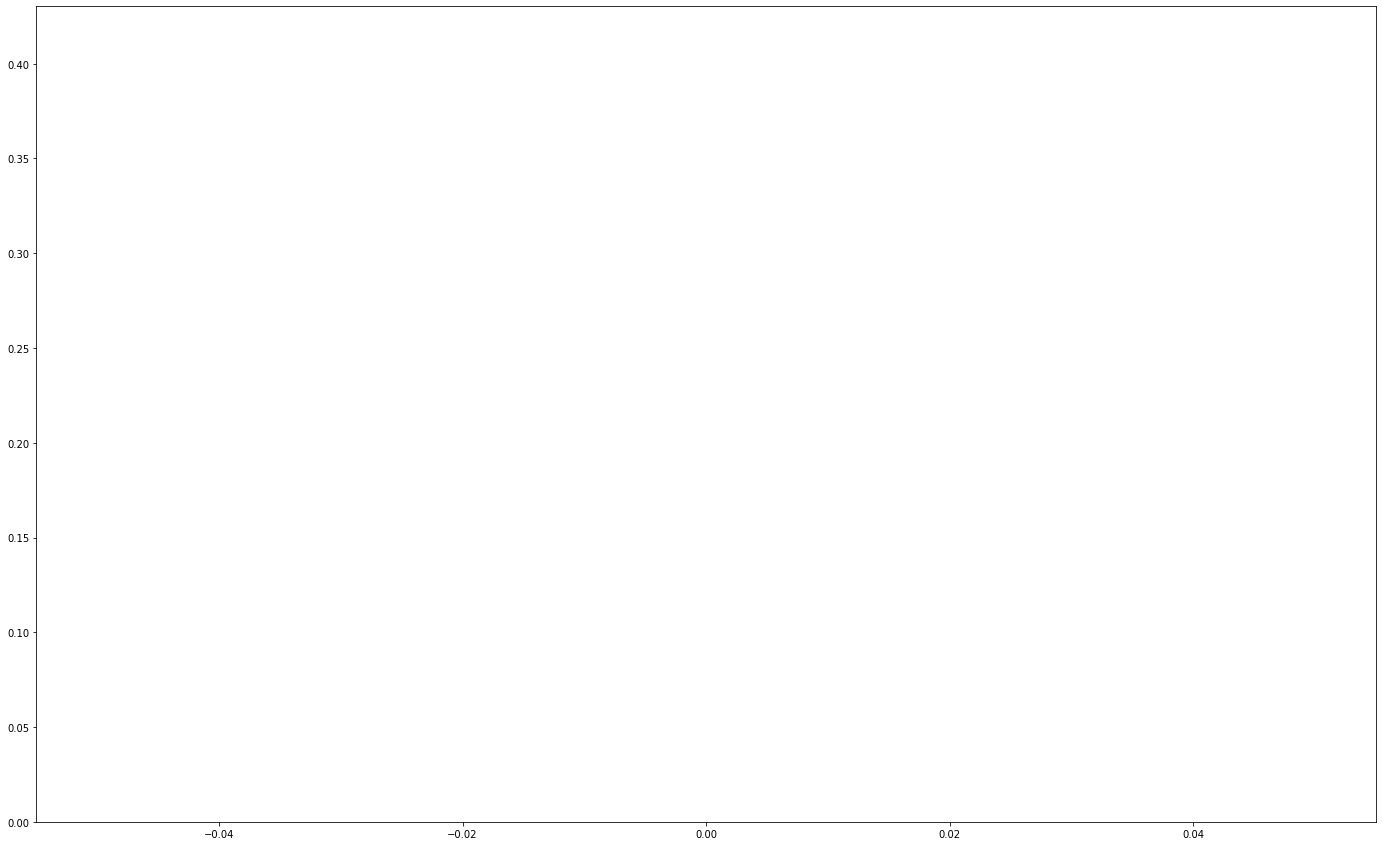

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.190814
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.090241
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.164148
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.261593
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.173586
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.271034
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.215463
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.241703
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.123391
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.069132

Test set: Average loss: 0.1823, Accuracy: 9471/10000 (95%)



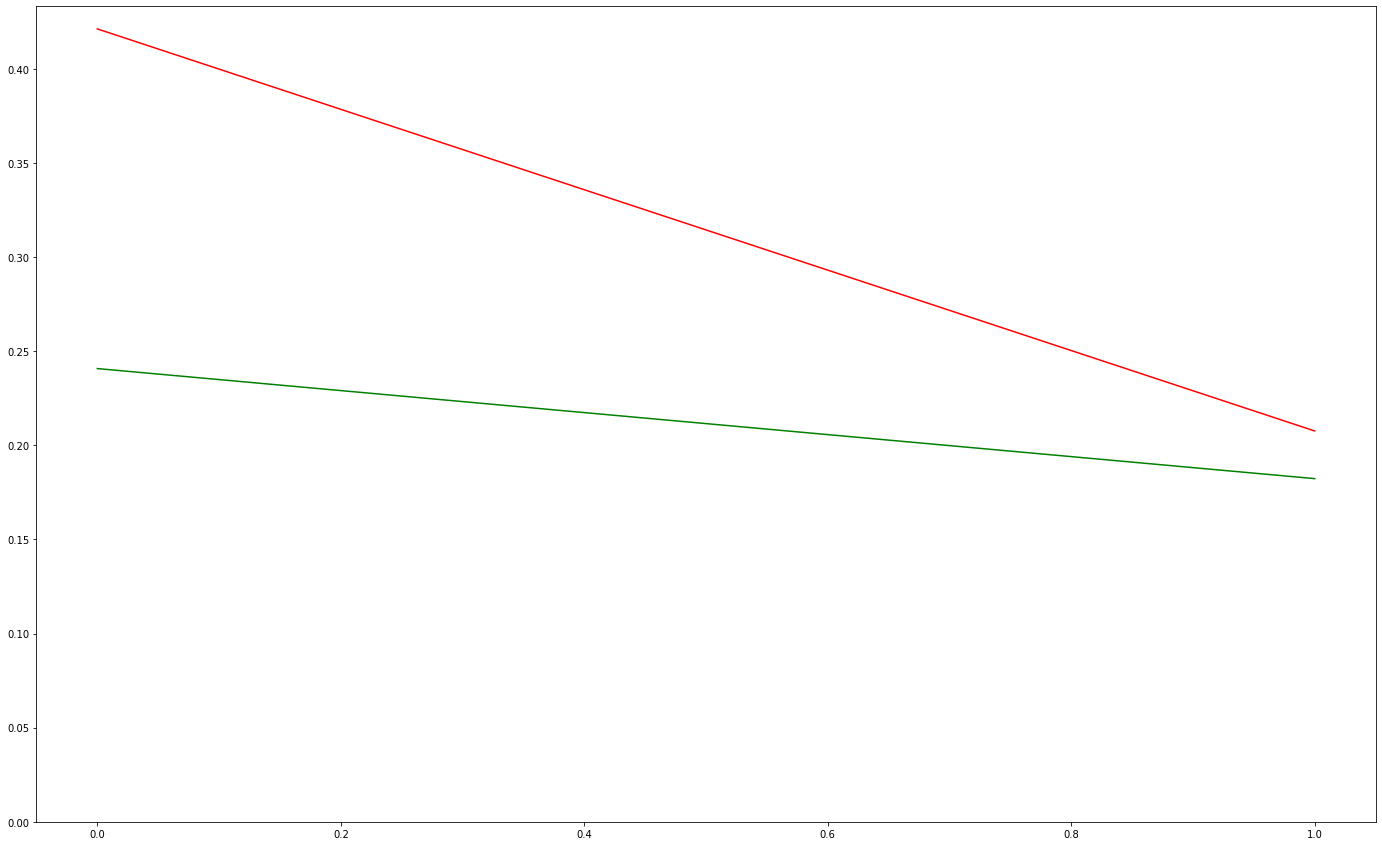

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.166942
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.079817
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.144201
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.193197
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.112311
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.219799
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.211732
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.113754
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.128803
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.128137

Test set: Average loss: 0.1583, Accuracy: 9525/10000 (95%)



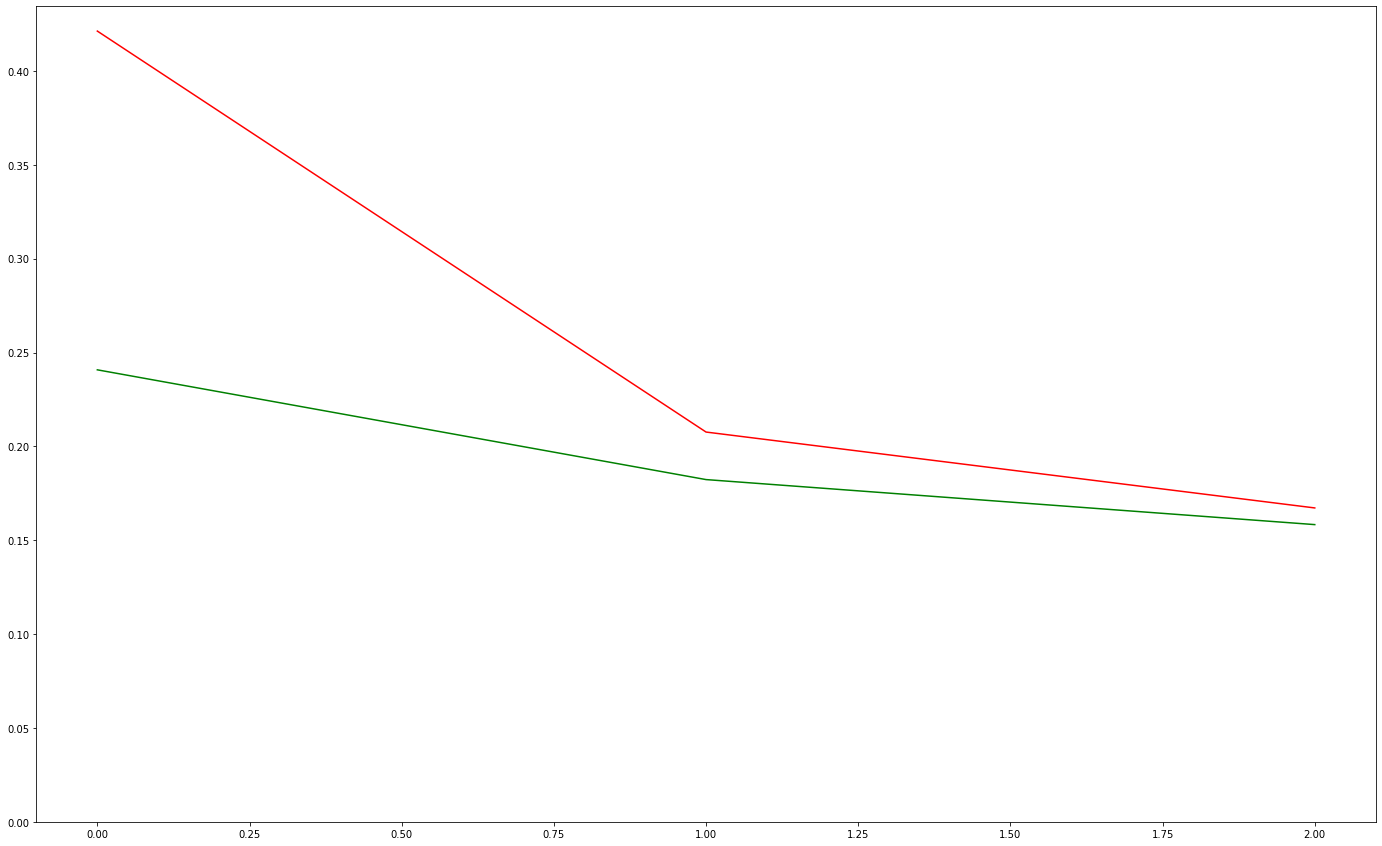

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.083014
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.081137
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.167205
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.139418
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.054375
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.114212
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.161278
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.244833
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.100476
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.055829

Test set: Average loss: 0.1441, Accuracy: 9562/10000 (96%)



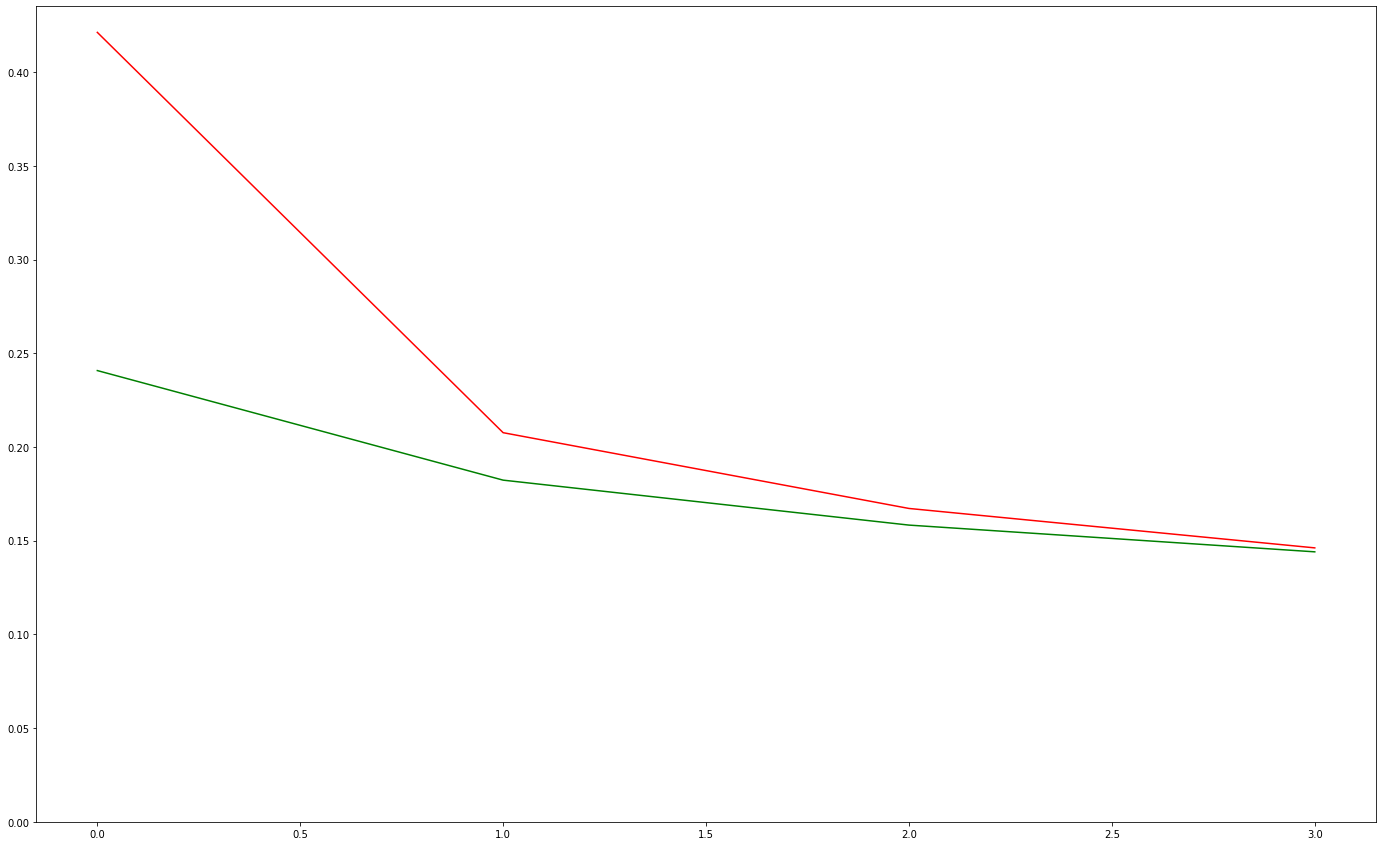

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.303135
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.089540
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.099667
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.122165
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.153029
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.099395
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.241829
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.141989
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.095461
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.046708

Test set: Average loss: 0.1352, Accuracy: 9592/10000 (96%)



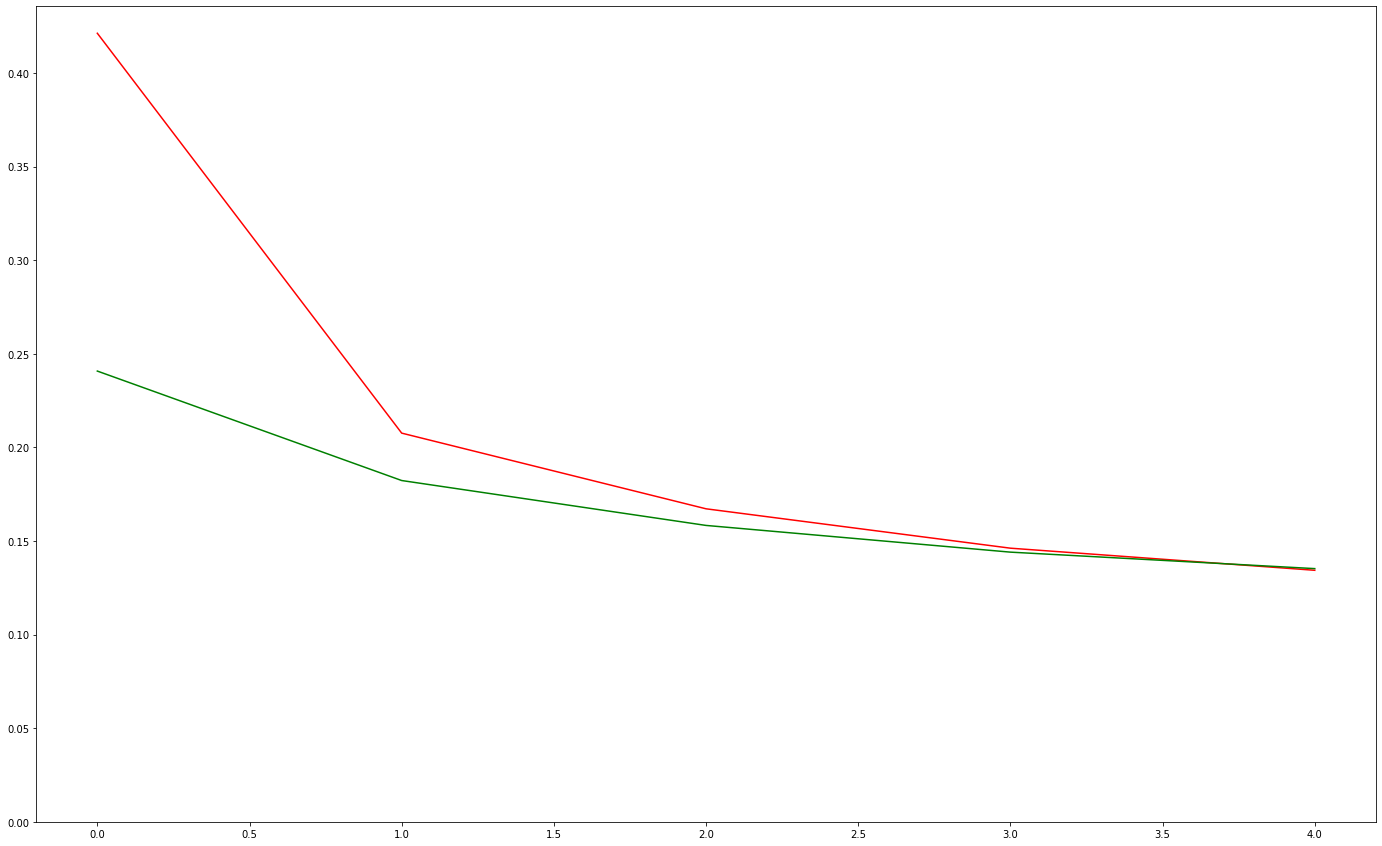

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.140453
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.150164
Train Epoch: 6 [12800/60000 (21%)]	Loss: 0.113316
Train Epoch: 6 [19200/60000 (32%)]	Loss: 0.200617
Train Epoch: 6 [25600/60000 (43%)]	Loss: 0.068235
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.114158
Train Epoch: 6 [38400/60000 (64%)]	Loss: 0.119312
Train Epoch: 6 [44800/60000 (75%)]	Loss: 0.060262
Train Epoch: 6 [51200/60000 (85%)]	Loss: 0.130270
Train Epoch: 6 [57600/60000 (96%)]	Loss: 0.055332

Test set: Average loss: 0.1309, Accuracy: 9607/10000 (96%)



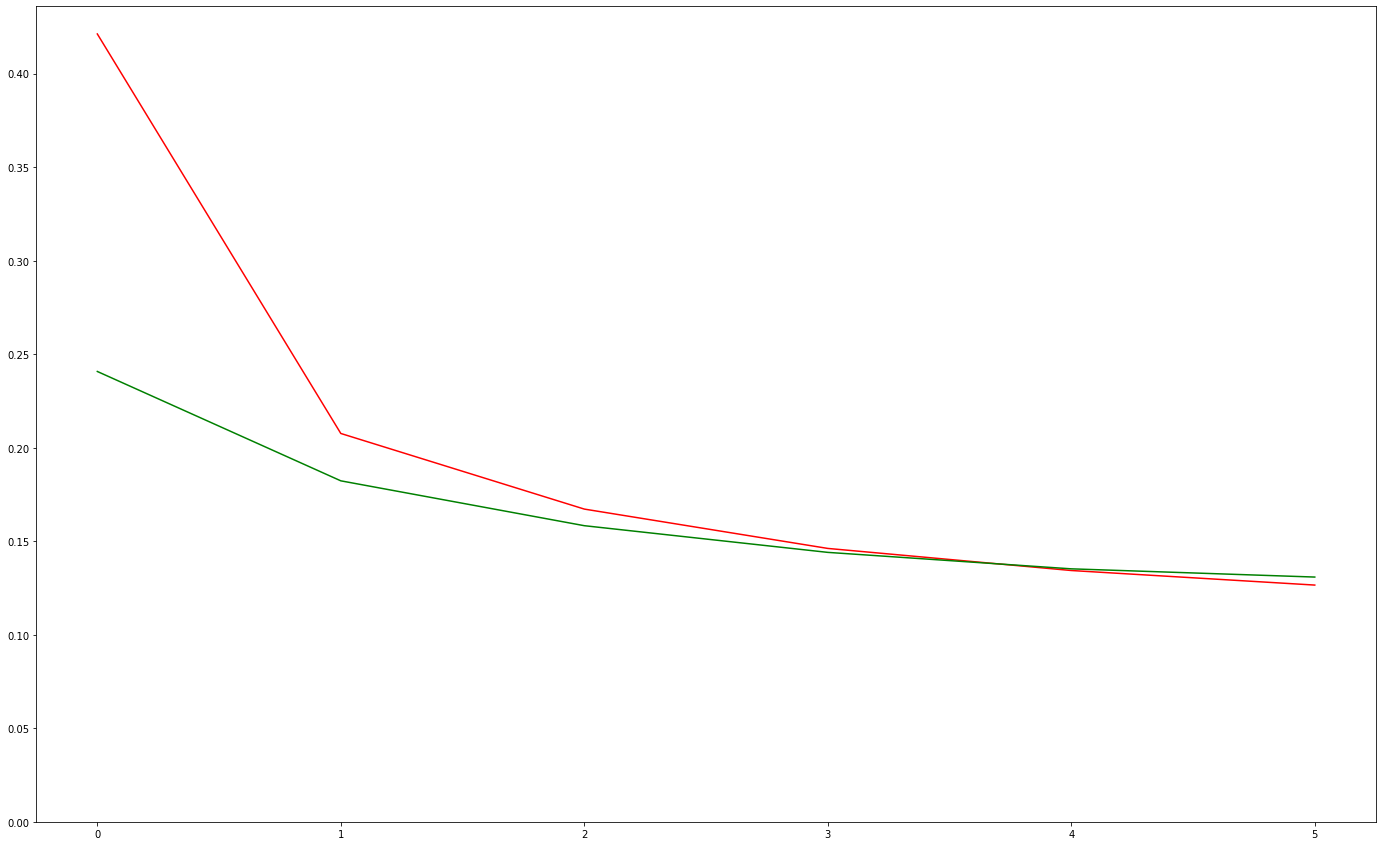

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.059001
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.122425
Train Epoch: 7 [12800/60000 (21%)]	Loss: 0.036489
Train Epoch: 7 [19200/60000 (32%)]	Loss: 0.117355
Train Epoch: 7 [25600/60000 (43%)]	Loss: 0.147199
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.073597
Train Epoch: 7 [38400/60000 (64%)]	Loss: 0.103346
Train Epoch: 7 [44800/60000 (75%)]	Loss: 0.123026
Train Epoch: 7 [51200/60000 (85%)]	Loss: 0.231126
Train Epoch: 7 [57600/60000 (96%)]	Loss: 0.047866

Test set: Average loss: 0.1275, Accuracy: 9610/10000 (96%)



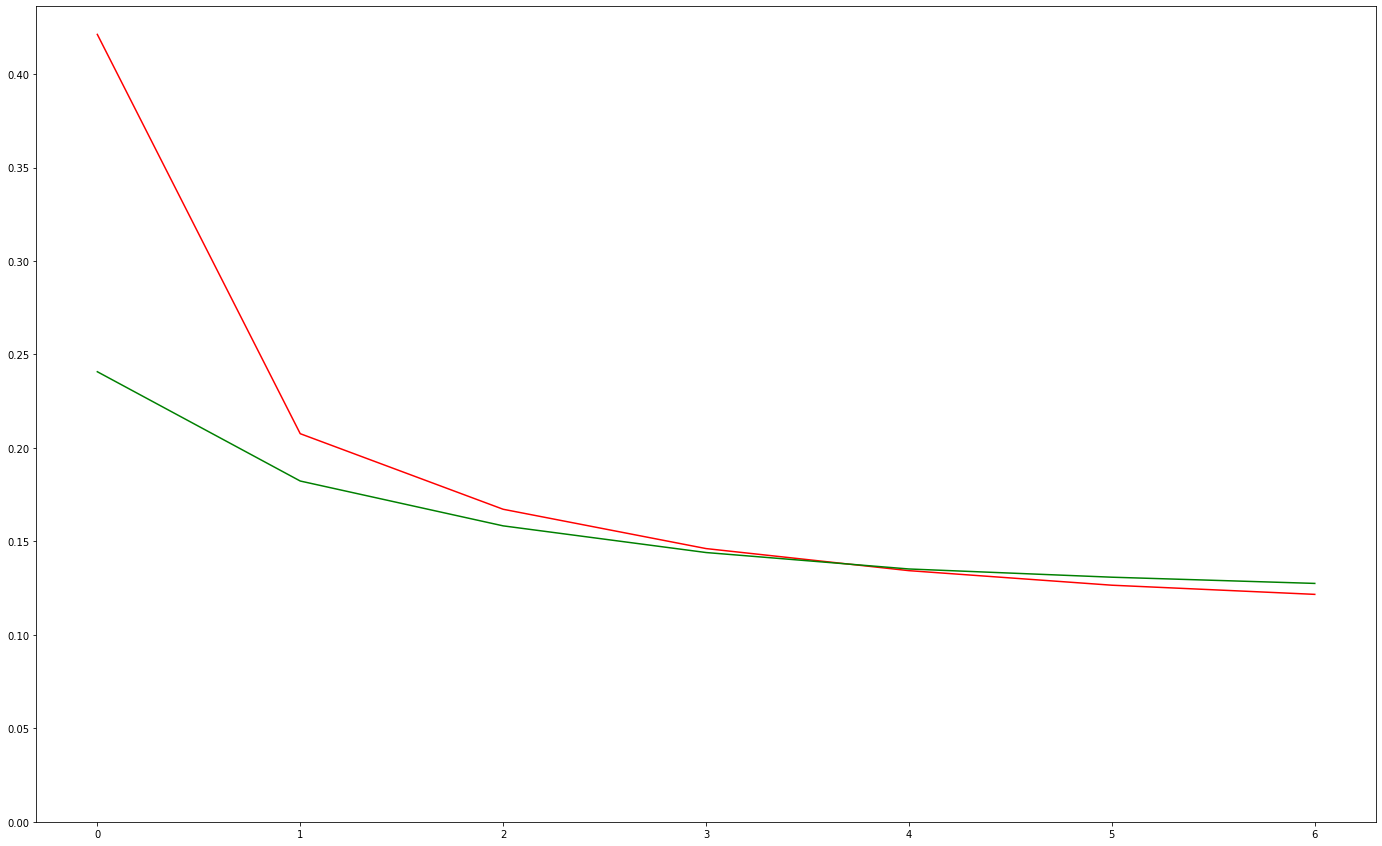

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.094555
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.094711
Train Epoch: 8 [12800/60000 (21%)]	Loss: 0.328970
Train Epoch: 8 [19200/60000 (32%)]	Loss: 0.104551
Train Epoch: 8 [25600/60000 (43%)]	Loss: 0.103948
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.107159
Train Epoch: 8 [38400/60000 (64%)]	Loss: 0.045007
Train Epoch: 8 [44800/60000 (75%)]	Loss: 0.230512
Train Epoch: 8 [51200/60000 (85%)]	Loss: 0.220621
Train Epoch: 8 [57600/60000 (96%)]	Loss: 0.224658

Test set: Average loss: 0.1264, Accuracy: 9618/10000 (96%)



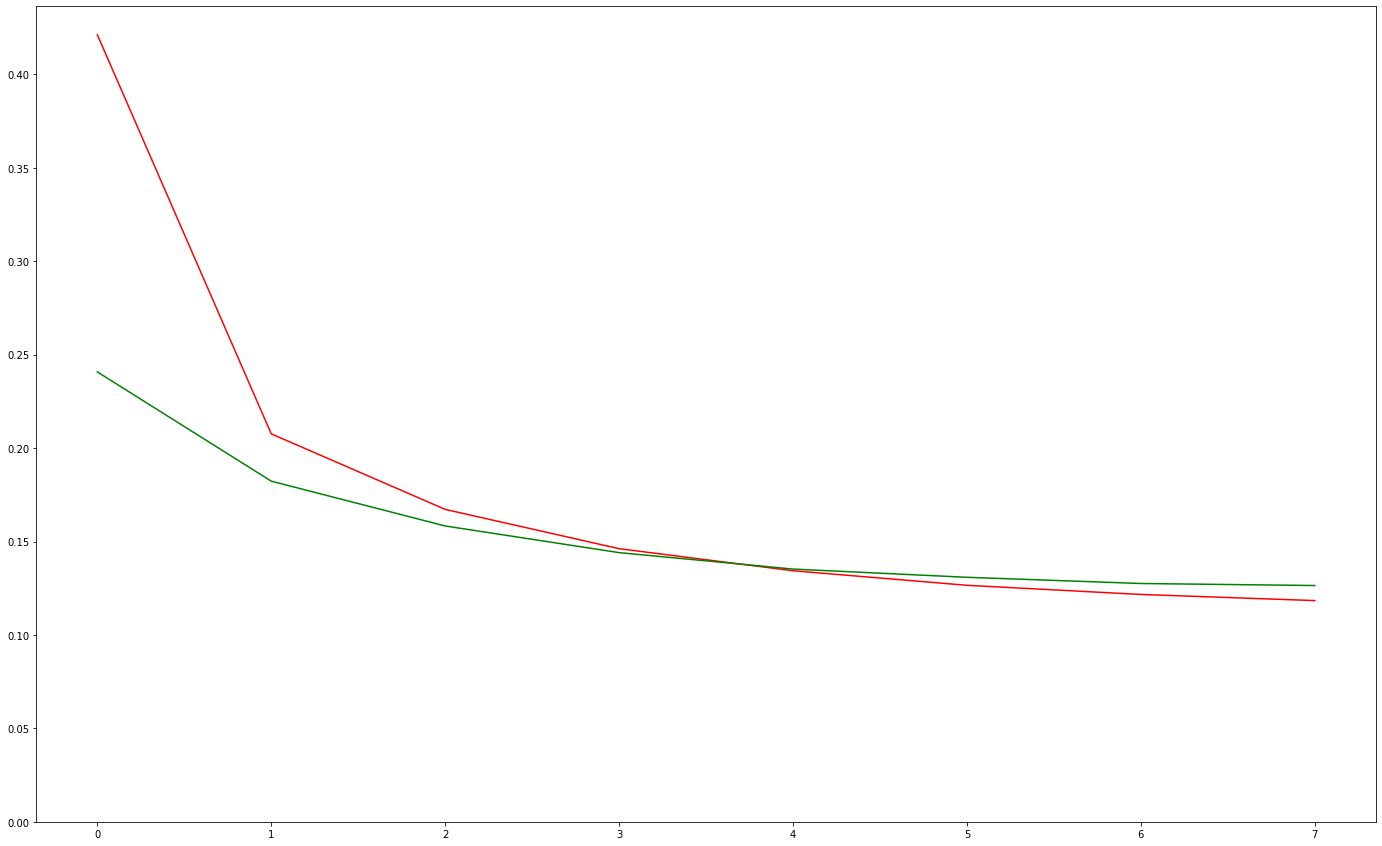

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.175667
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.059564
Train Epoch: 9 [12800/60000 (21%)]	Loss: 0.143567
Train Epoch: 9 [19200/60000 (32%)]	Loss: 0.178732
Train Epoch: 9 [25600/60000 (43%)]	Loss: 0.218366
Train Epoch: 9 [32000/60000 (53%)]	Loss: 0.072664
Train Epoch: 9 [38400/60000 (64%)]	Loss: 0.297409
Train Epoch: 9 [44800/60000 (75%)]	Loss: 0.021007
Train Epoch: 9 [51200/60000 (85%)]	Loss: 0.254473
Train Epoch: 9 [57600/60000 (96%)]	Loss: 0.214334

Test set: Average loss: 0.1248, Accuracy: 9630/10000 (96%)



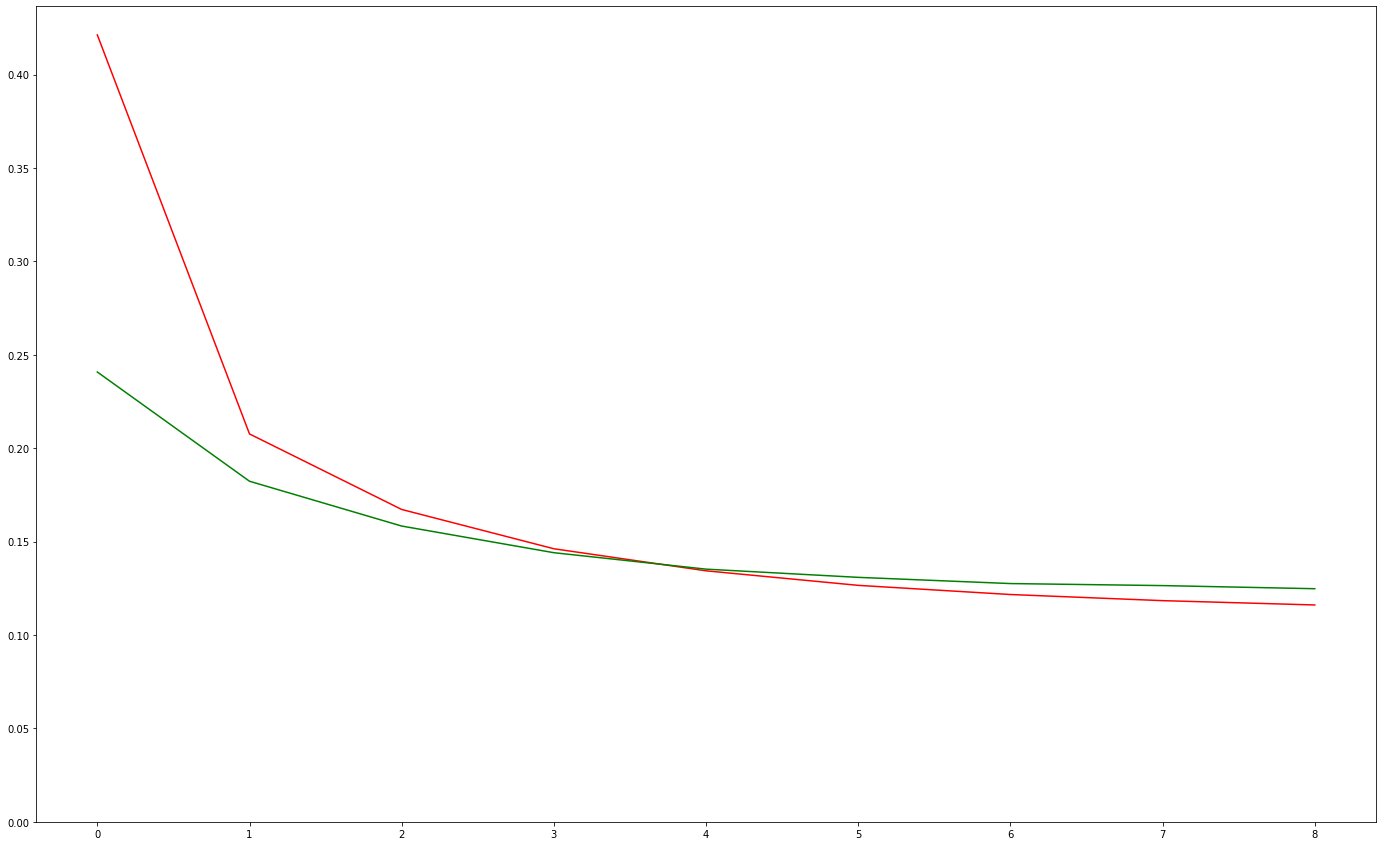

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.138131
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.122927
Train Epoch: 10 [12800/60000 (21%)]	Loss: 0.263445
Train Epoch: 10 [19200/60000 (32%)]	Loss: 0.089630
Train Epoch: 10 [25600/60000 (43%)]	Loss: 0.091490
Train Epoch: 10 [32000/60000 (53%)]	Loss: 0.089591
Train Epoch: 10 [38400/60000 (64%)]	Loss: 0.062533
Train Epoch: 10 [44800/60000 (75%)]	Loss: 0.038036
Train Epoch: 10 [51200/60000 (85%)]	Loss: 0.027042
Train Epoch: 10 [57600/60000 (96%)]	Loss: 0.098317

Test set: Average loss: 0.1240, Accuracy: 9632/10000 (96%)



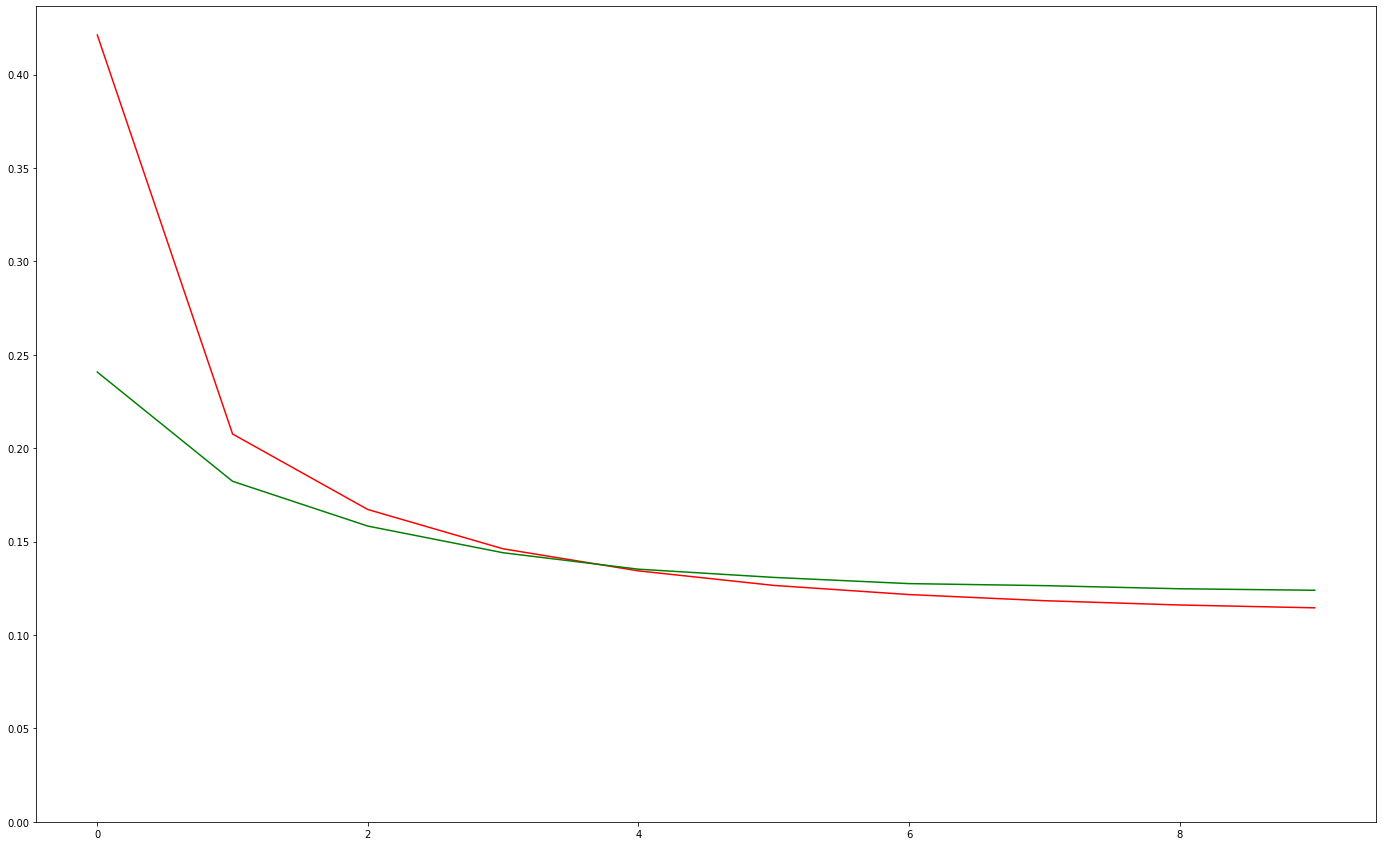

In [5]:
epochs          = 10
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

model = Simple_net(100, 10).to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    test(model, device, test_loader, test_loss)
    scheduler.step()

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

In [6]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
fc1.weight 	 torch.Size([100, 784])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([100, 100])
fc2.bias 	 torch.Size([100])
fc3.weight 	 torch.Size([10, 100])
fc3.bias 	 torch.Size([10])


In [7]:
# Save
torch.save(model.state_dict(), "model.pth")

In [8]:
# Load
model_copy = Simple_net(100, 10).to(device)
model_copy.load_state_dict(torch.load("model.pth"))
model_copy.eval()

Simple_net(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)

In [9]:
print("Copy of model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model_copy.state_dict()[param_tensor].size())

Copy of model's state_dict:
fc1.weight 	 torch.Size([100, 784])
fc1.bias 	 torch.Size([100])
fc2.weight 	 torch.Size([100, 100])
fc2.bias 	 torch.Size([100])
fc3.weight 	 torch.Size([10, 100])
fc3.bias 	 torch.Size([10])


In [10]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../data/cifar-10-python.tar.gz to ../data


In [11]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

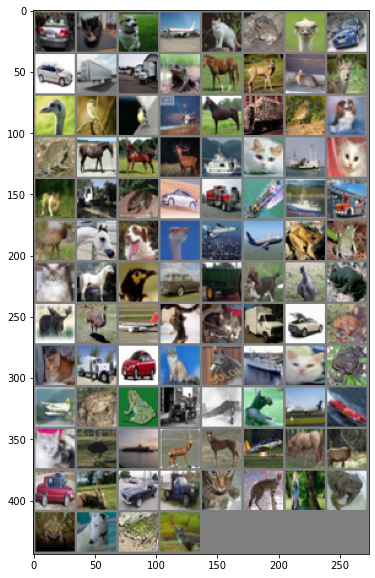

In [12]:
import torchvision

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [13]:
class Conv_net(nn.Module):
    def __init__(self):
        super(Conv_net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.conv3 = nn.Conv2d(128, 256, 3)
        self.dropout = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 1024)
        self.fc2 = nn.Linear(1024, 10)

    def forward(self, x):
        #torch.Size([100, 3, 32, 32])
        x = self.conv1(x)
        x = F.relu(x)

        #torch.Size([100, 64, 30, 30])
        x = self.conv2(x)
        x = F.relu(x)

        #torch.Size([100, 128, 28, 28]
        x = F.max_pool2d(x, 2)

        #torch.Size([100, 128, 14, 14])
        x = self.conv3(x)
        x = F.relu(x)

        #torch.Size([100, 256, 12, 12])
        x = F.max_pool2d(x, 2)

        #torch.Size([100, 256, 6, 6])        
        x = torch.flatten(x, 1)
        
        x = self.dropout(x)

        #torch.Size([100, 9216])
        x = self.fc1(x)
        x = F.relu(x)
  
        x = self.dropout(x)

        #torch.Size([100, 1024])
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        #torch.Size([100, 10])
        return output

Train Epoch: 1 [0/50000 (0%)]	Loss: 2.304511
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.899348
Train Epoch: 1 [20000/50000 (40%)]	Loss: 1.639611
Train Epoch: 1 [30000/50000 (60%)]	Loss: 1.582532
Train Epoch: 1 [40000/50000 (80%)]	Loss: 1.459213

Test set: Average loss: 1.1390, Accuracy: 5968/10000 (60%)



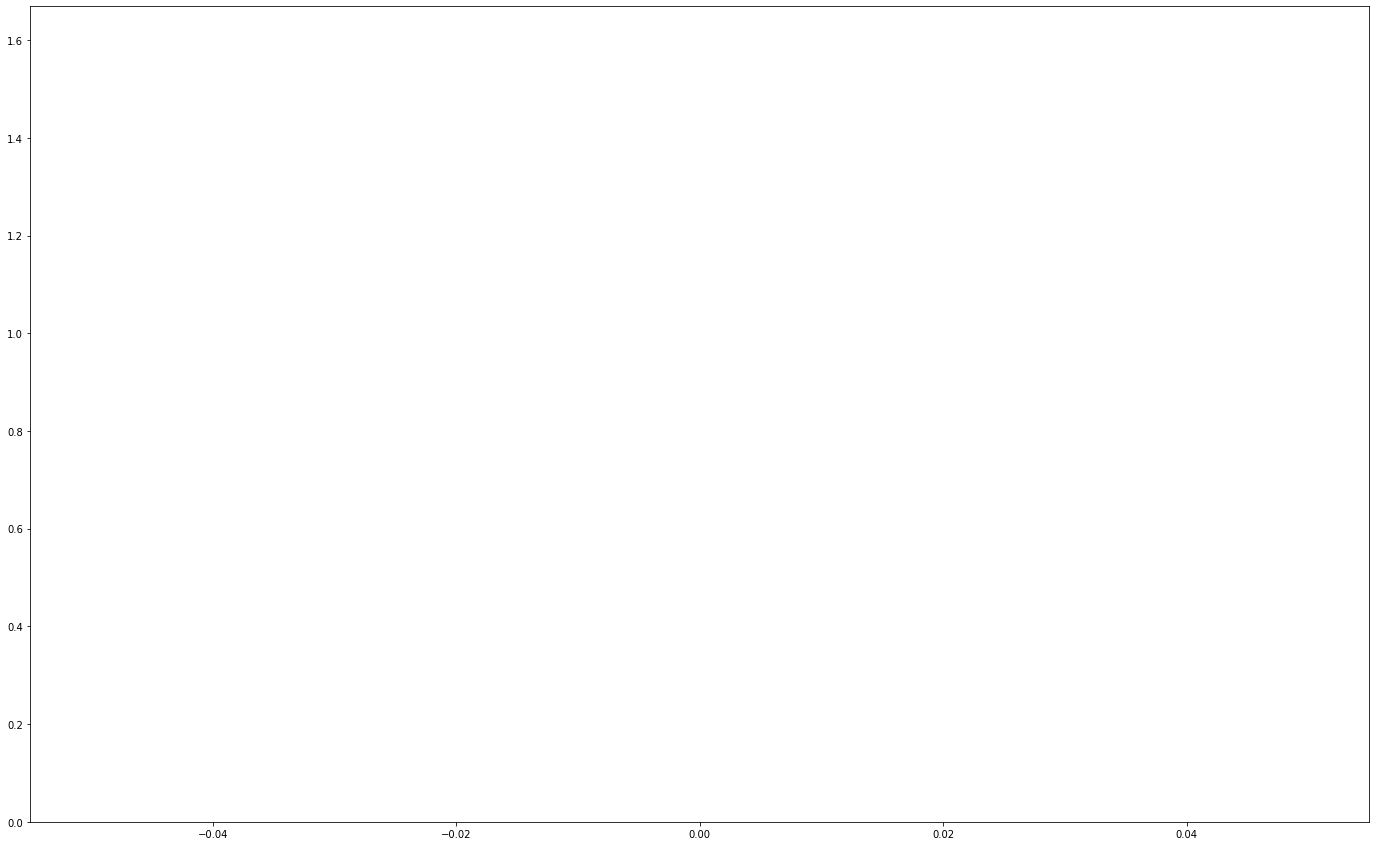

Train Epoch: 2 [0/50000 (0%)]	Loss: 1.227129
Train Epoch: 2 [10000/50000 (20%)]	Loss: 1.091929
Train Epoch: 2 [20000/50000 (40%)]	Loss: 1.438625
Train Epoch: 2 [30000/50000 (60%)]	Loss: 1.001970
Train Epoch: 2 [40000/50000 (80%)]	Loss: 0.976061

Test set: Average loss: 0.9932, Accuracy: 6548/10000 (65%)



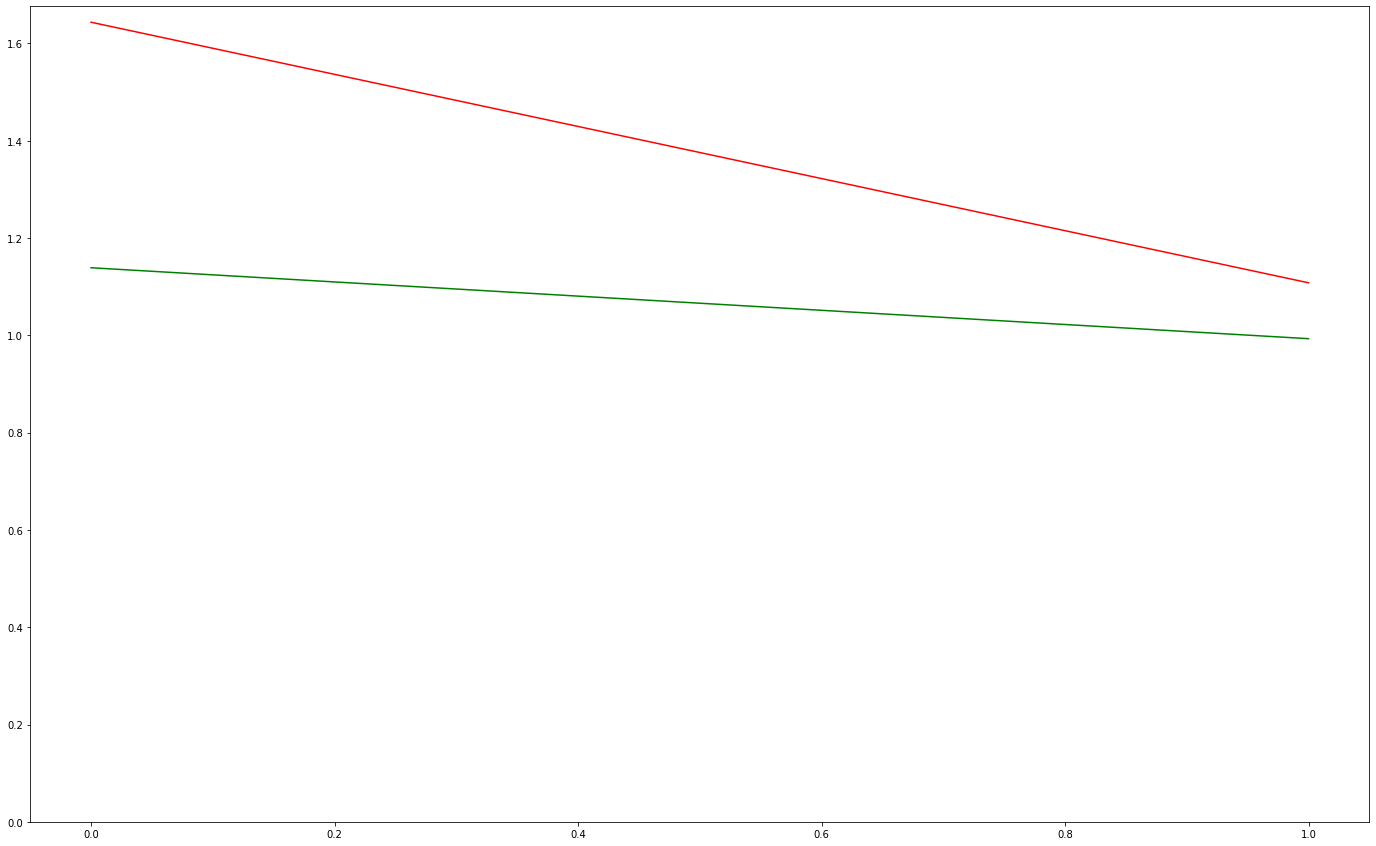

Train Epoch: 3 [0/50000 (0%)]	Loss: 1.012758
Train Epoch: 3 [10000/50000 (20%)]	Loss: 0.807842
Train Epoch: 3 [20000/50000 (40%)]	Loss: 0.817237
Train Epoch: 3 [30000/50000 (60%)]	Loss: 0.652114
Train Epoch: 3 [40000/50000 (80%)]	Loss: 0.851275

Test set: Average loss: 0.7602, Accuracy: 7403/10000 (74%)



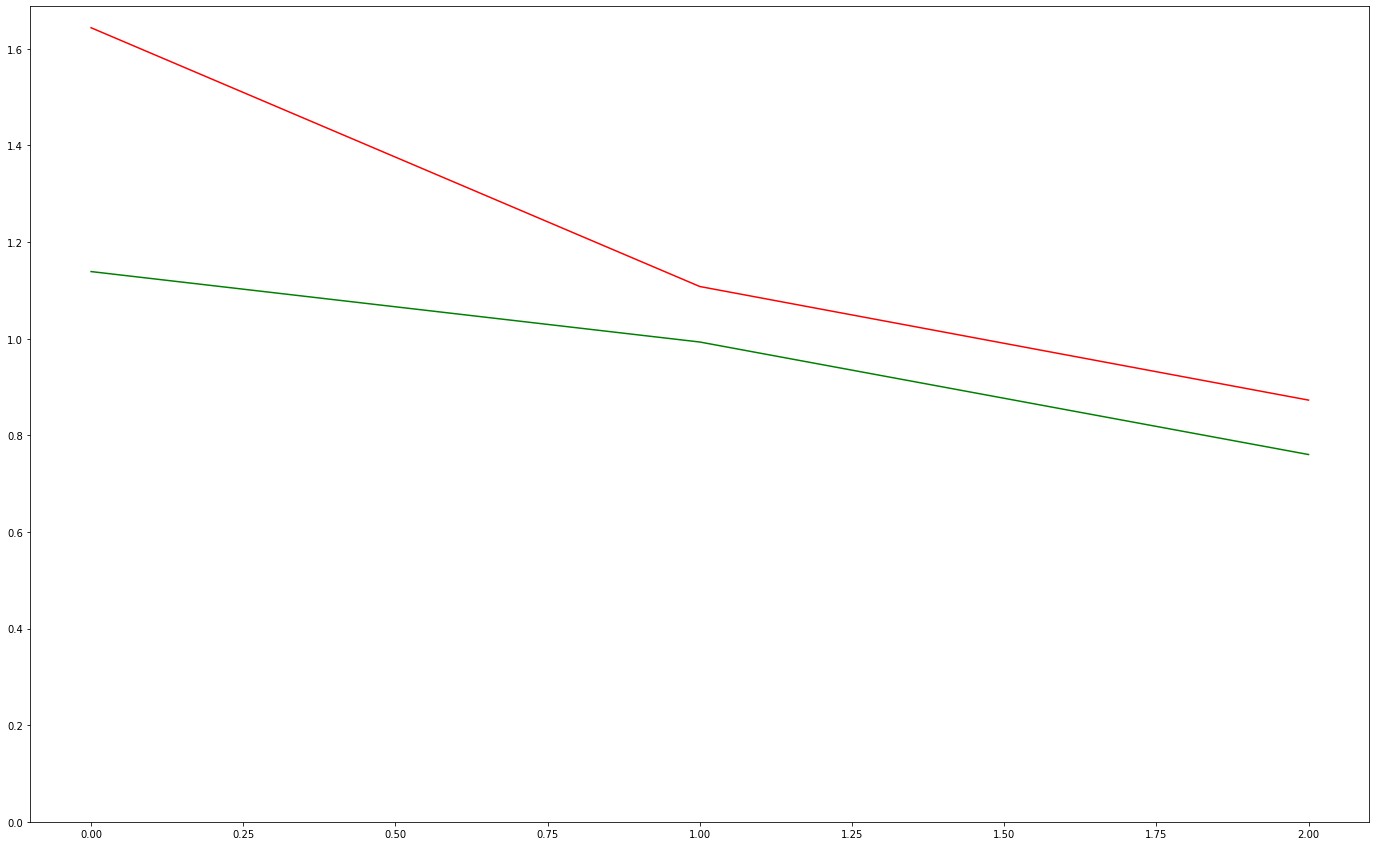

Train Epoch: 4 [0/50000 (0%)]	Loss: 0.597248
Train Epoch: 4 [10000/50000 (20%)]	Loss: 0.915674
Train Epoch: 4 [20000/50000 (40%)]	Loss: 0.684397
Train Epoch: 4 [30000/50000 (60%)]	Loss: 0.725549
Train Epoch: 4 [40000/50000 (80%)]	Loss: 0.805818

Test set: Average loss: 0.6996, Accuracy: 7614/10000 (76%)



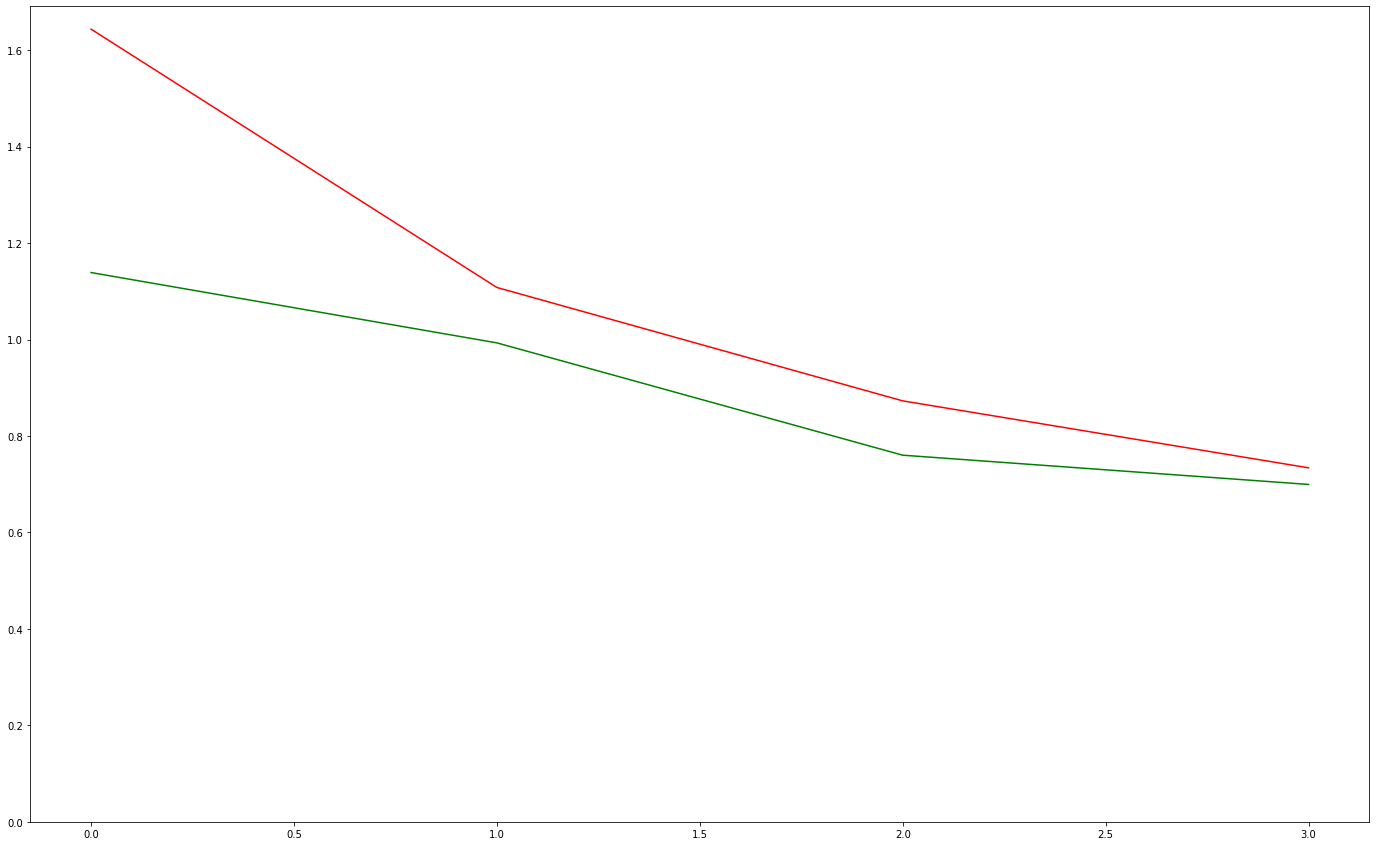

Train Epoch: 5 [0/50000 (0%)]	Loss: 0.566288
Train Epoch: 5 [10000/50000 (20%)]	Loss: 0.461509
Train Epoch: 5 [20000/50000 (40%)]	Loss: 0.582886
Train Epoch: 5 [30000/50000 (60%)]	Loss: 0.738997
Train Epoch: 5 [40000/50000 (80%)]	Loss: 0.695713

Test set: Average loss: 0.7149, Accuracy: 7600/10000 (76%)



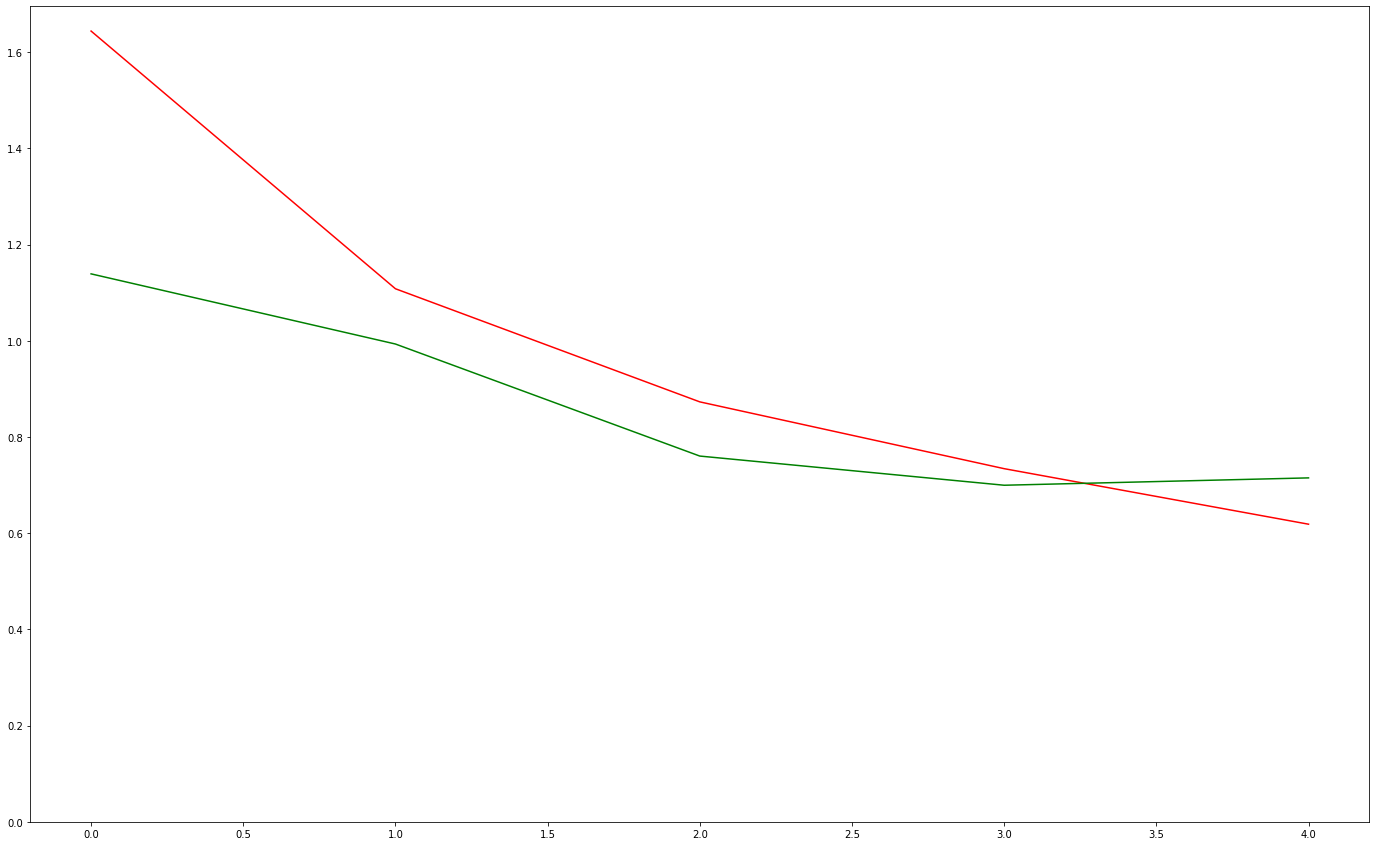

Train Epoch: 6 [0/50000 (0%)]	Loss: 0.484361
Train Epoch: 6 [10000/50000 (20%)]	Loss: 0.416298
Train Epoch: 6 [20000/50000 (40%)]	Loss: 0.422154
Train Epoch: 6 [30000/50000 (60%)]	Loss: 0.381459
Train Epoch: 6 [40000/50000 (80%)]	Loss: 0.426496

Test set: Average loss: 0.6322, Accuracy: 7883/10000 (79%)



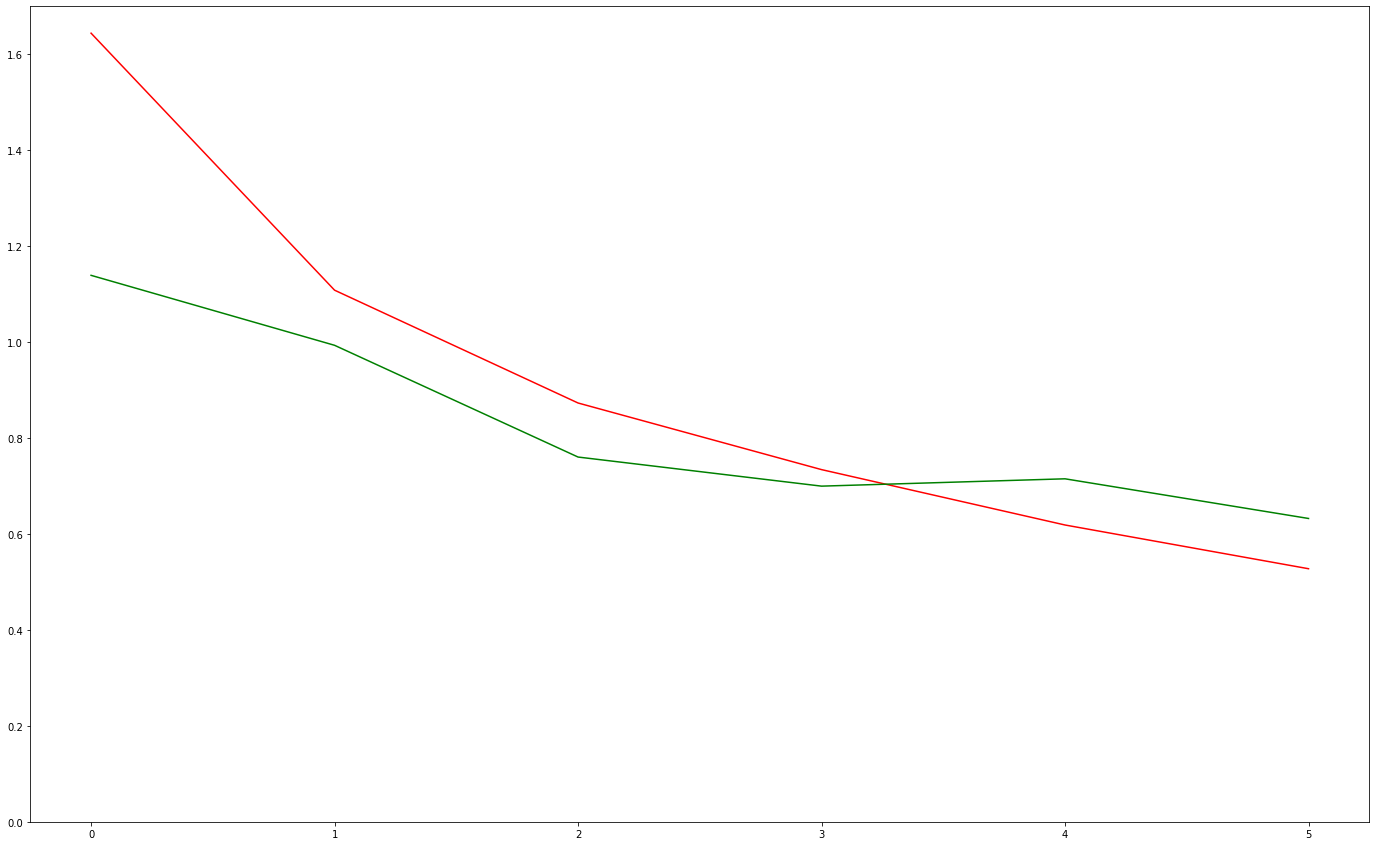

Train Epoch: 7 [0/50000 (0%)]	Loss: 0.419819
Train Epoch: 7 [10000/50000 (20%)]	Loss: 0.531421
Train Epoch: 7 [20000/50000 (40%)]	Loss: 0.479315
Train Epoch: 7 [30000/50000 (60%)]	Loss: 0.542973
Train Epoch: 7 [40000/50000 (80%)]	Loss: 0.300168

Test set: Average loss: 0.5966, Accuracy: 8003/10000 (80%)



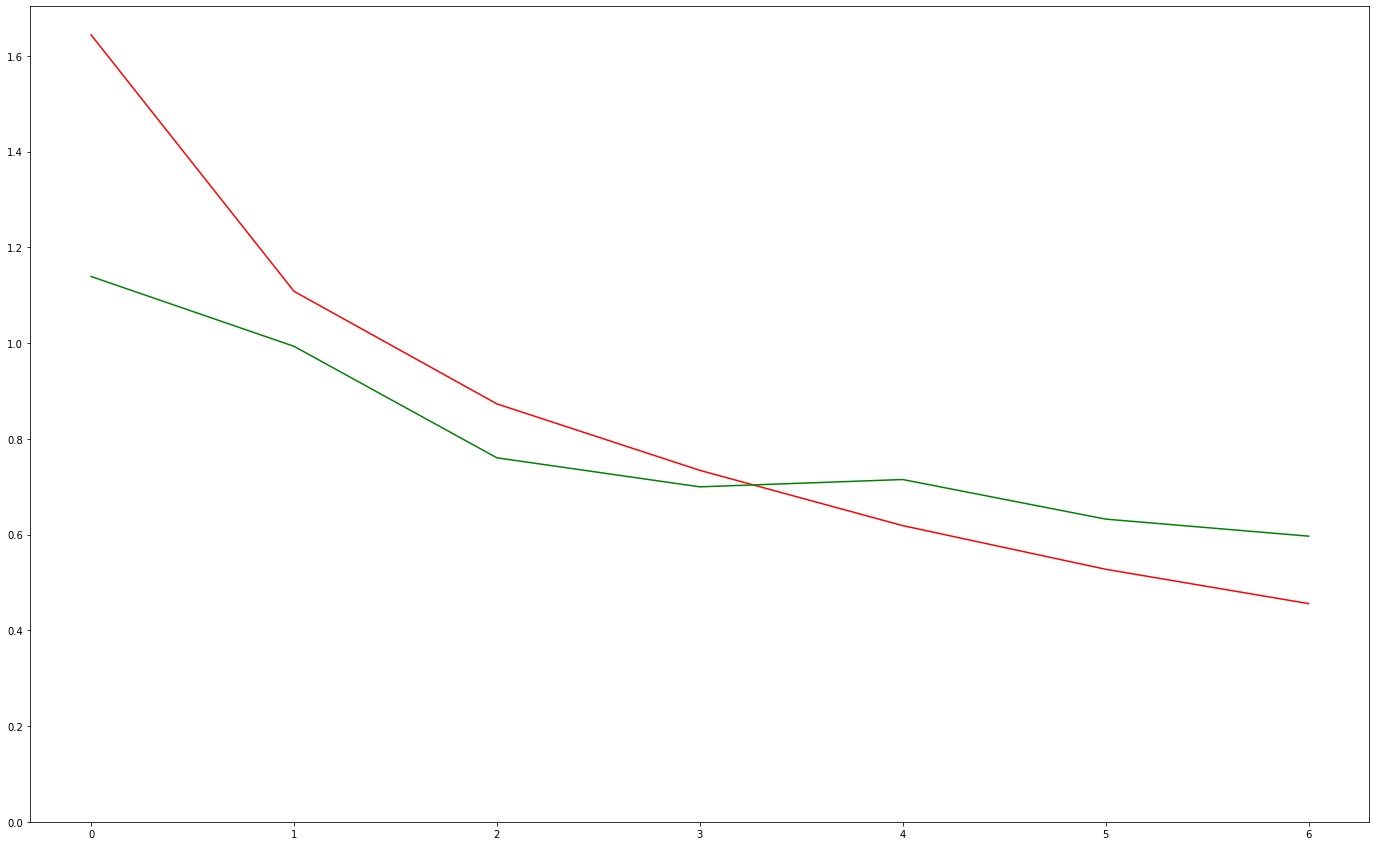

Train Epoch: 8 [0/50000 (0%)]	Loss: 0.362495
Train Epoch: 8 [10000/50000 (20%)]	Loss: 0.425312
Train Epoch: 8 [20000/50000 (40%)]	Loss: 0.306413
Train Epoch: 8 [30000/50000 (60%)]	Loss: 0.334294
Train Epoch: 8 [40000/50000 (80%)]	Loss: 0.297536

Test set: Average loss: 0.5864, Accuracy: 8073/10000 (81%)



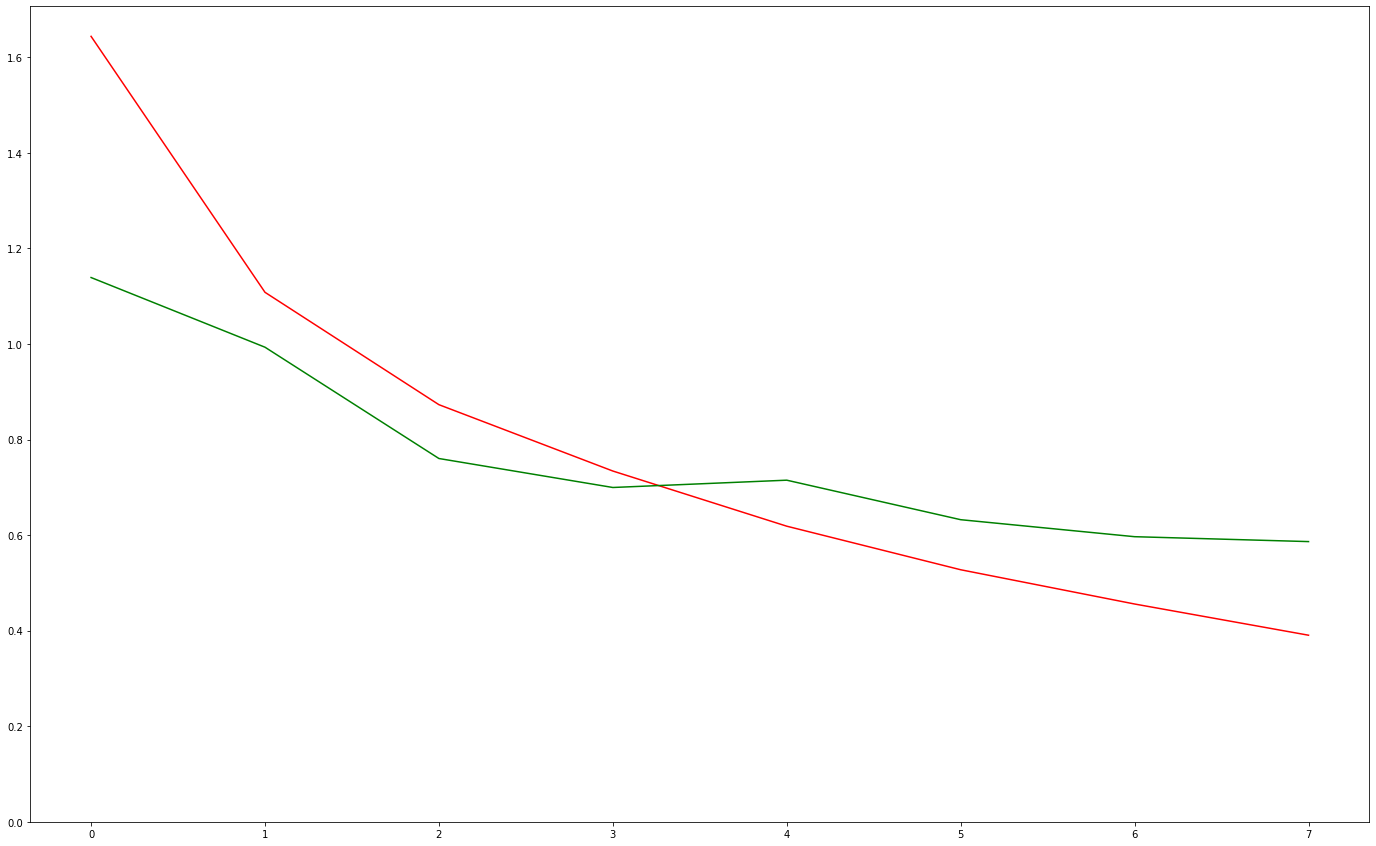

Train Epoch: 9 [0/50000 (0%)]	Loss: 0.281475
Train Epoch: 9 [10000/50000 (20%)]	Loss: 0.347383
Train Epoch: 9 [20000/50000 (40%)]	Loss: 0.419153
Train Epoch: 9 [30000/50000 (60%)]	Loss: 0.435881
Train Epoch: 9 [40000/50000 (80%)]	Loss: 0.334437

Test set: Average loss: 0.5911, Accuracy: 8106/10000 (81%)



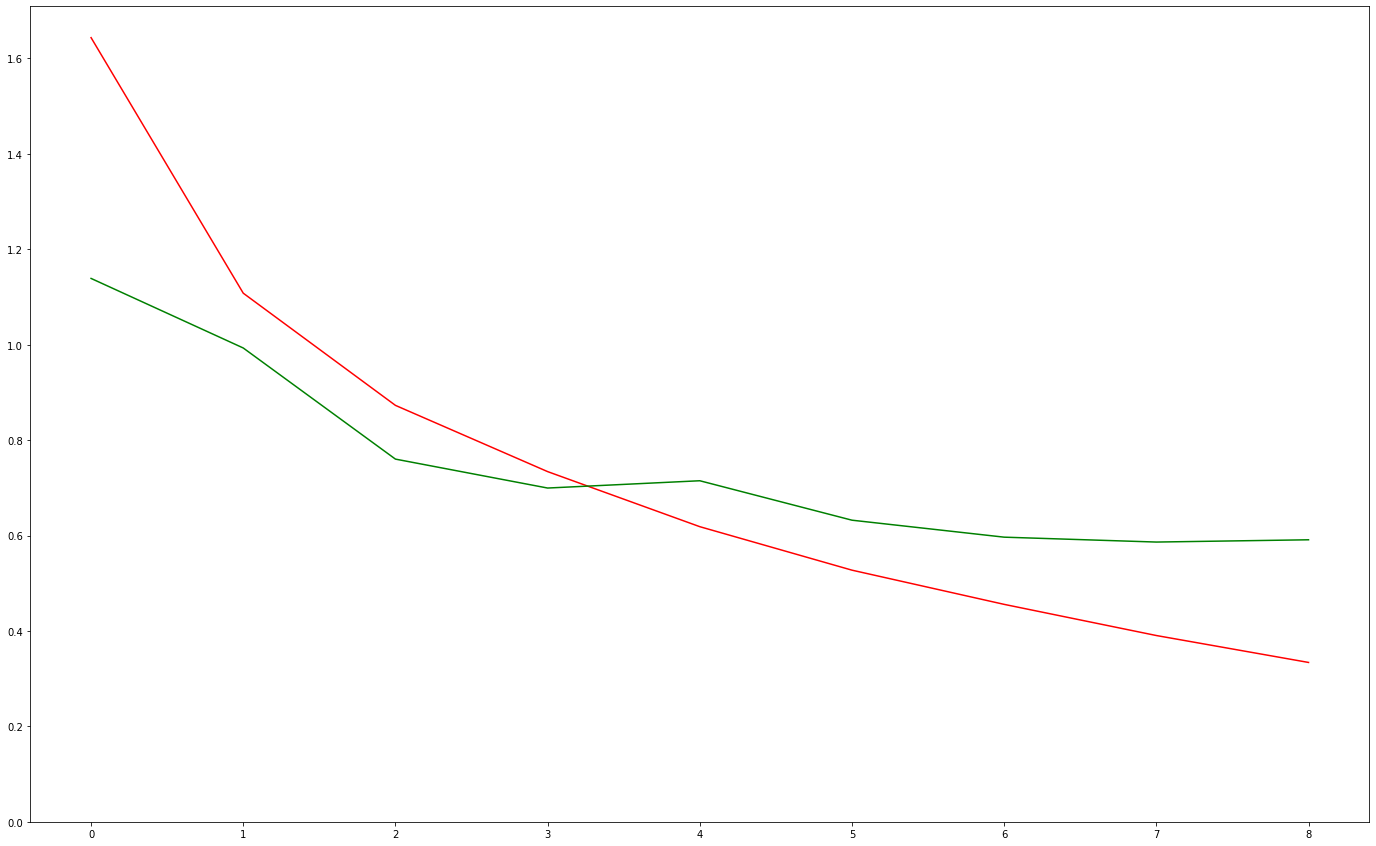

Train Epoch: 10 [0/50000 (0%)]	Loss: 0.362169
Train Epoch: 10 [10000/50000 (20%)]	Loss: 0.177449
Train Epoch: 10 [20000/50000 (40%)]	Loss: 0.249069
Train Epoch: 10 [30000/50000 (60%)]	Loss: 0.217499
Train Epoch: 10 [40000/50000 (80%)]	Loss: 0.300713

Test set: Average loss: 0.5954, Accuracy: 8132/10000 (81%)



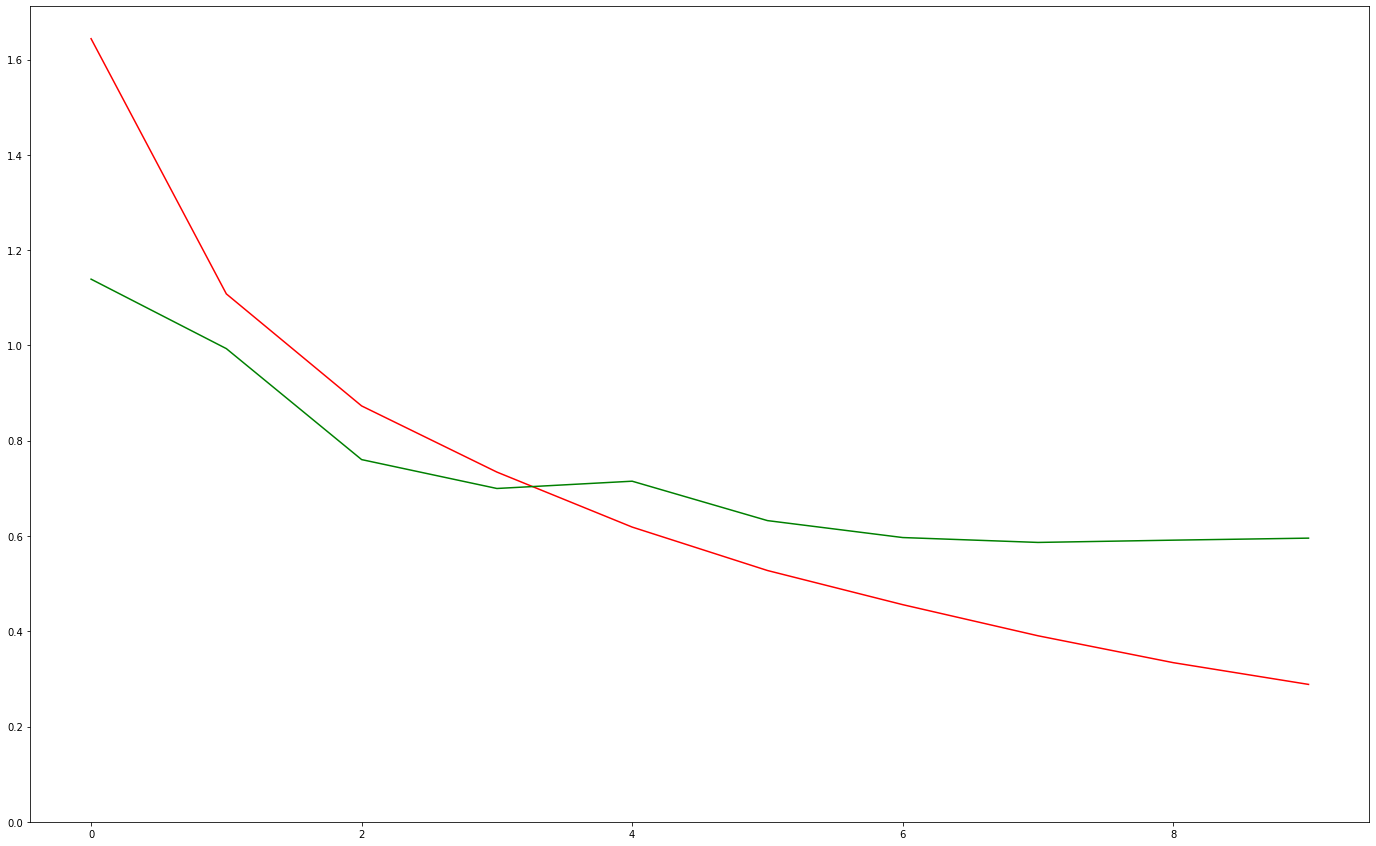

Train Epoch: 11 [0/50000 (0%)]	Loss: 0.281381
Train Epoch: 11 [10000/50000 (20%)]	Loss: 0.122491
Train Epoch: 11 [20000/50000 (40%)]	Loss: 0.286185
Train Epoch: 11 [30000/50000 (60%)]	Loss: 0.229931
Train Epoch: 11 [40000/50000 (80%)]	Loss: 0.242492

Test set: Average loss: 0.5719, Accuracy: 8180/10000 (82%)



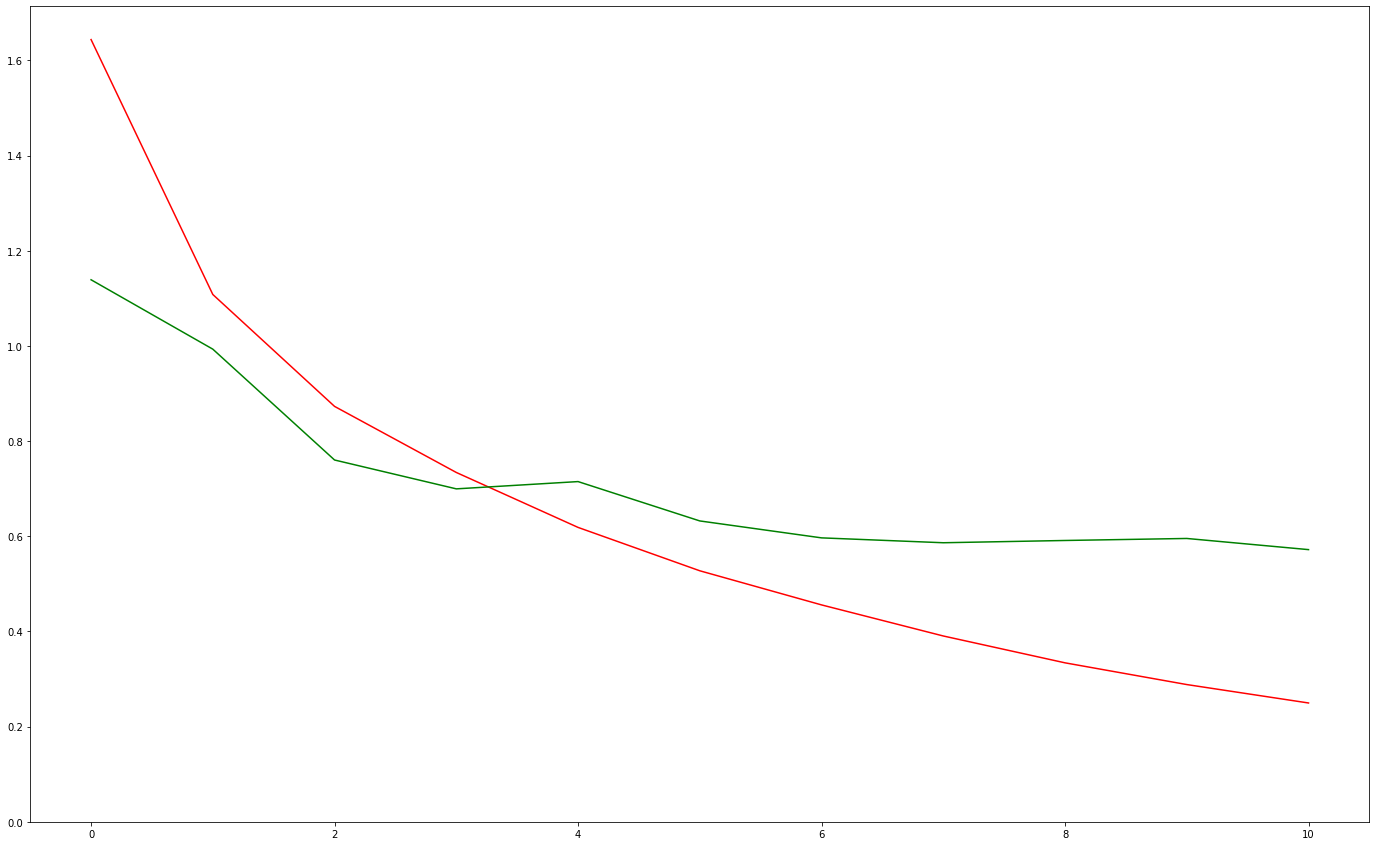

Train Epoch: 12 [0/50000 (0%)]	Loss: 0.205132
Train Epoch: 12 [10000/50000 (20%)]	Loss: 0.092350
Train Epoch: 12 [20000/50000 (40%)]	Loss: 0.261733
Train Epoch: 12 [30000/50000 (60%)]	Loss: 0.215252
Train Epoch: 12 [40000/50000 (80%)]	Loss: 0.360117

Test set: Average loss: 0.5966, Accuracy: 8227/10000 (82%)



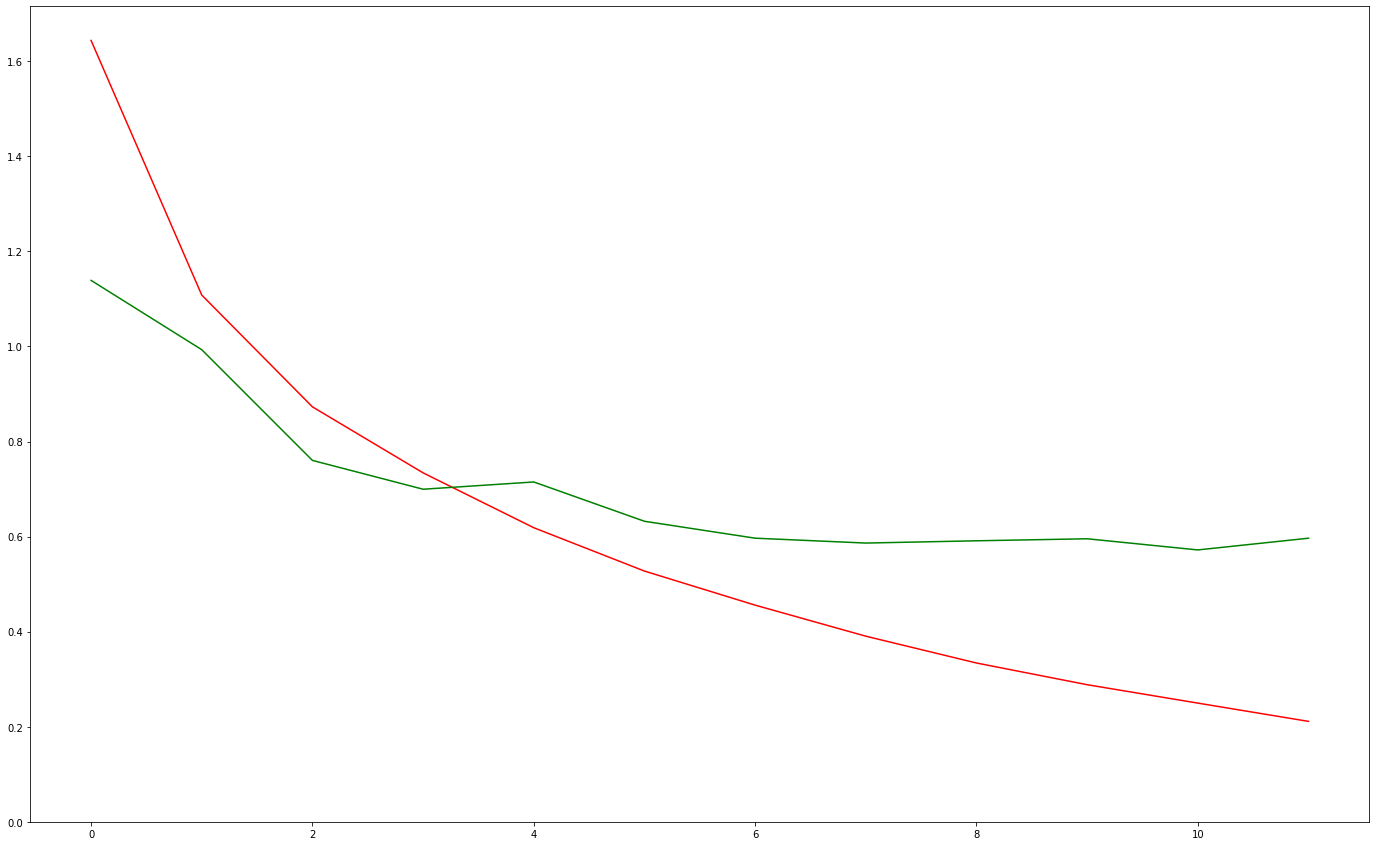

Train Epoch: 13 [0/50000 (0%)]	Loss: 0.164219
Train Epoch: 13 [10000/50000 (20%)]	Loss: 0.199320
Train Epoch: 13 [20000/50000 (40%)]	Loss: 0.218814
Train Epoch: 13 [30000/50000 (60%)]	Loss: 0.150221
Train Epoch: 13 [40000/50000 (80%)]	Loss: 0.172286

Test set: Average loss: 0.5962, Accuracy: 8254/10000 (83%)



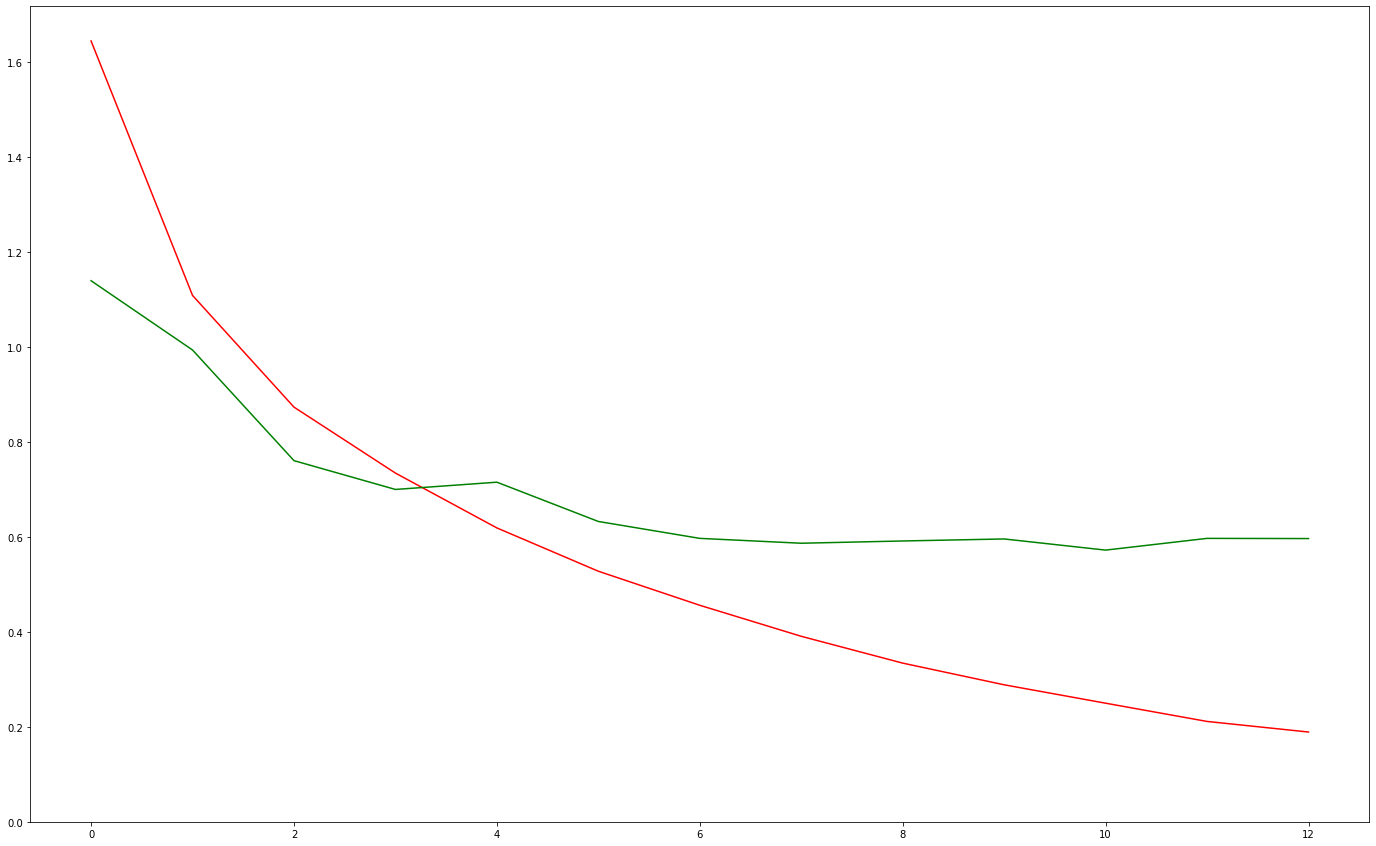

Train Epoch: 14 [0/50000 (0%)]	Loss: 0.146026
Train Epoch: 14 [10000/50000 (20%)]	Loss: 0.162930
Train Epoch: 14 [20000/50000 (40%)]	Loss: 0.140412
Train Epoch: 14 [30000/50000 (60%)]	Loss: 0.165380
Train Epoch: 14 [40000/50000 (80%)]	Loss: 0.201544

Test set: Average loss: 0.6390, Accuracy: 8199/10000 (82%)



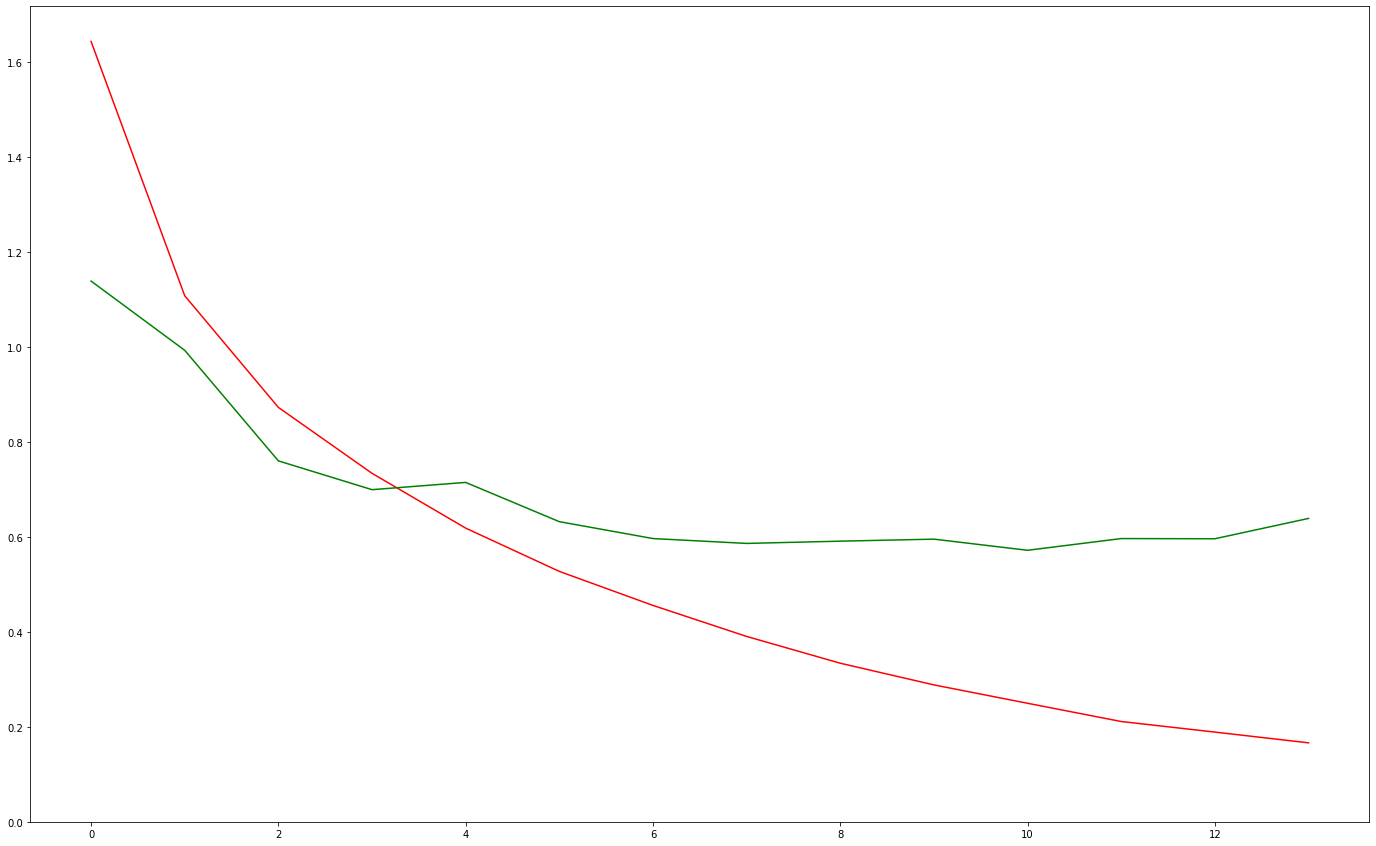

Train Epoch: 15 [0/50000 (0%)]	Loss: 0.289828
Train Epoch: 15 [10000/50000 (20%)]	Loss: 0.121155
Train Epoch: 15 [20000/50000 (40%)]	Loss: 0.145764
Train Epoch: 15 [30000/50000 (60%)]	Loss: 0.120843
Train Epoch: 15 [40000/50000 (80%)]	Loss: 0.068514

Test set: Average loss: 0.6258, Accuracy: 8296/10000 (83%)



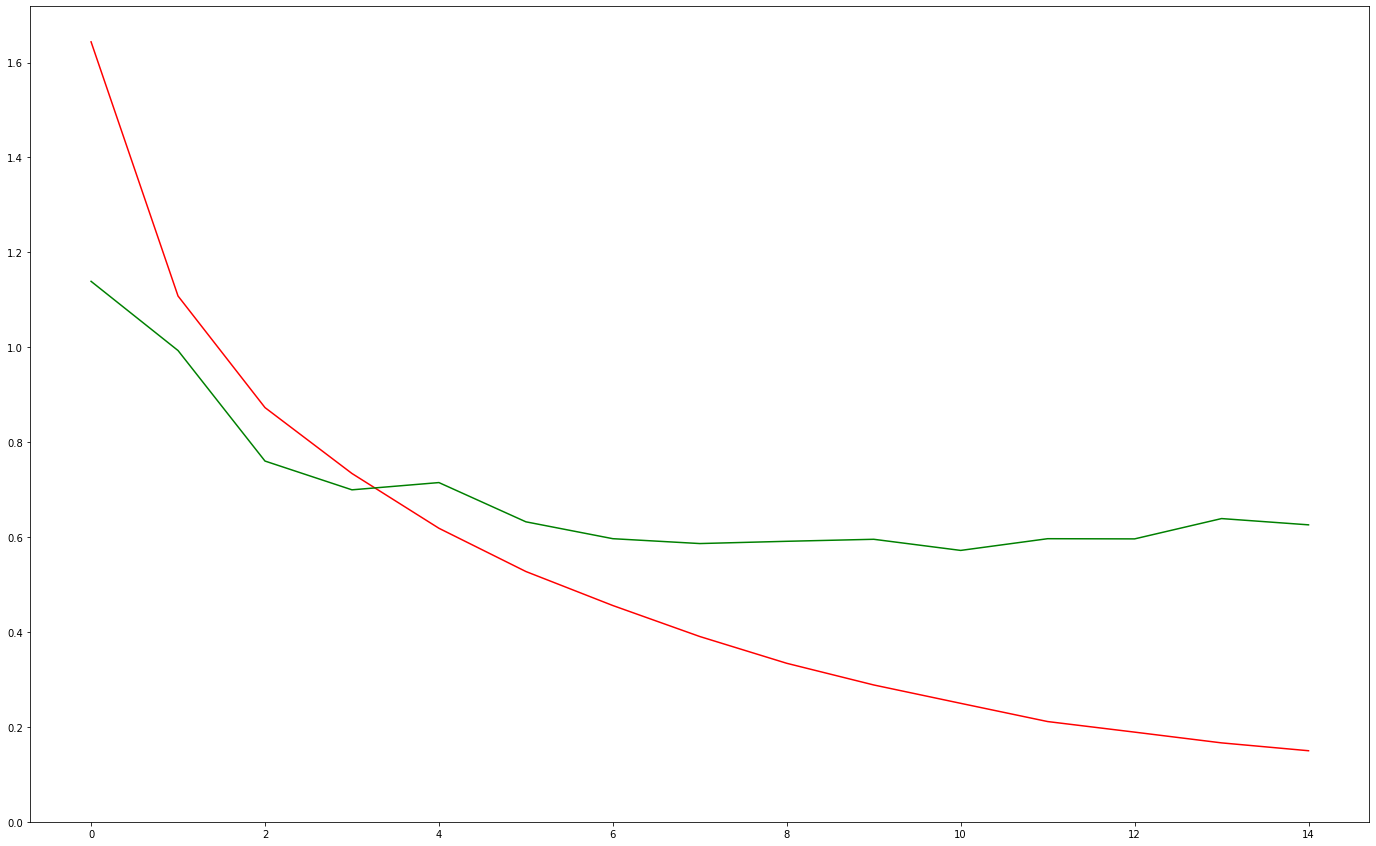

In [ ]:
epochs          = 15
lr              = 1
gamma           = 0.9
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")


model = Conv_net().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    test(model, device, test_loader, test_loss)
    scheduler.step()

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

In [24]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [88]:
from torch.utils.data import Dataset
import os
class MyDigitsDataset(Dataset):
  def __init__(self, path='/content/gdrive/MyDrive/digits/', transform=None):
    self.path = path
    digits = os.listdir(self.path)
    self.samples = np.concatenate([os.listdir(self.path)])
    if transform is None:
      self.should_transform = False
    else:
      self.transform = transform
      self.should_transform = True

  def __len__(self):
    return self.samples.size
  
  def __getitem__(self, idx):
    digit = self.samples[idx]
    img_path = self.path
    img = cv2.imread(img_path + digit, cv2.IMREAD_UNCHANGED)
    img = img[:, :, 2]
    if self.should_transform:
      img = self.transform(img)
    return img, torch.tensor(int(digit[0]))

In [89]:
my_dataset = MyDigitsDataset(transform=transforms.Compose([
                        transforms.ToPILImage(),                        
                        transforms.GaussianBlur(kernel_size=3, sigma=0.5),
                        transforms.ToTensor(),
                    ]))

In [90]:
test_loader = torch.utils.data.DataLoader(my_dataset, batch_size=1, shuffle=True, **kwargs)

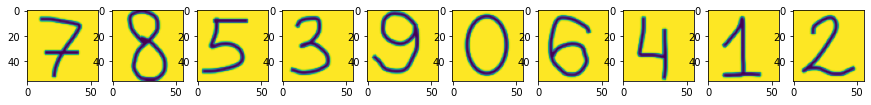

In [91]:
i = 0
plt.figure(figsize=(15, 15))
for data, target in test_loader:
    img = data[0].permute(1, 2, 0).numpy()
    i +=1
    plt.subplot(5, 10, i)
    plt.imshow(img[:, :, 0])
plt.show()

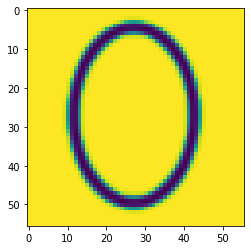

In [92]:
for data, target in test_loader:
    img = data[0].permute(1, 2, 0).numpy()
    plt.imshow(img[:, :, 0])
    break
plt.show()

In [93]:
class Conv_net_MNIST(nn.Module):
    def __init__(self):
        super(Conv_net_MNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        #torch.Size([64, 1, 28, 28])
        x = self.conv1(x)
        #torch.Size([64, 32, 26, 26])
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        #torch.Size([64, 64, 12, 12])
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        #torch.Size([64, 9216])
        x = self.fc1(x)
        #torch.Size([64, 128])
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        #torch.Size([64, 10])
        output = F.log_softmax(x, dim=1)
        #torch.Size([64, 10])
        return output

In [94]:
batch_size = 50
no_cuda         = False
use_cuda = not no_cuda and torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.321725
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.361728
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.410531
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.220838
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.234652
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.211014
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.158262
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.235438
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.215556
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.155351
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.159431
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.213005

Test set: Average loss: 1.1387, Accuracy: 36/50 (72%)



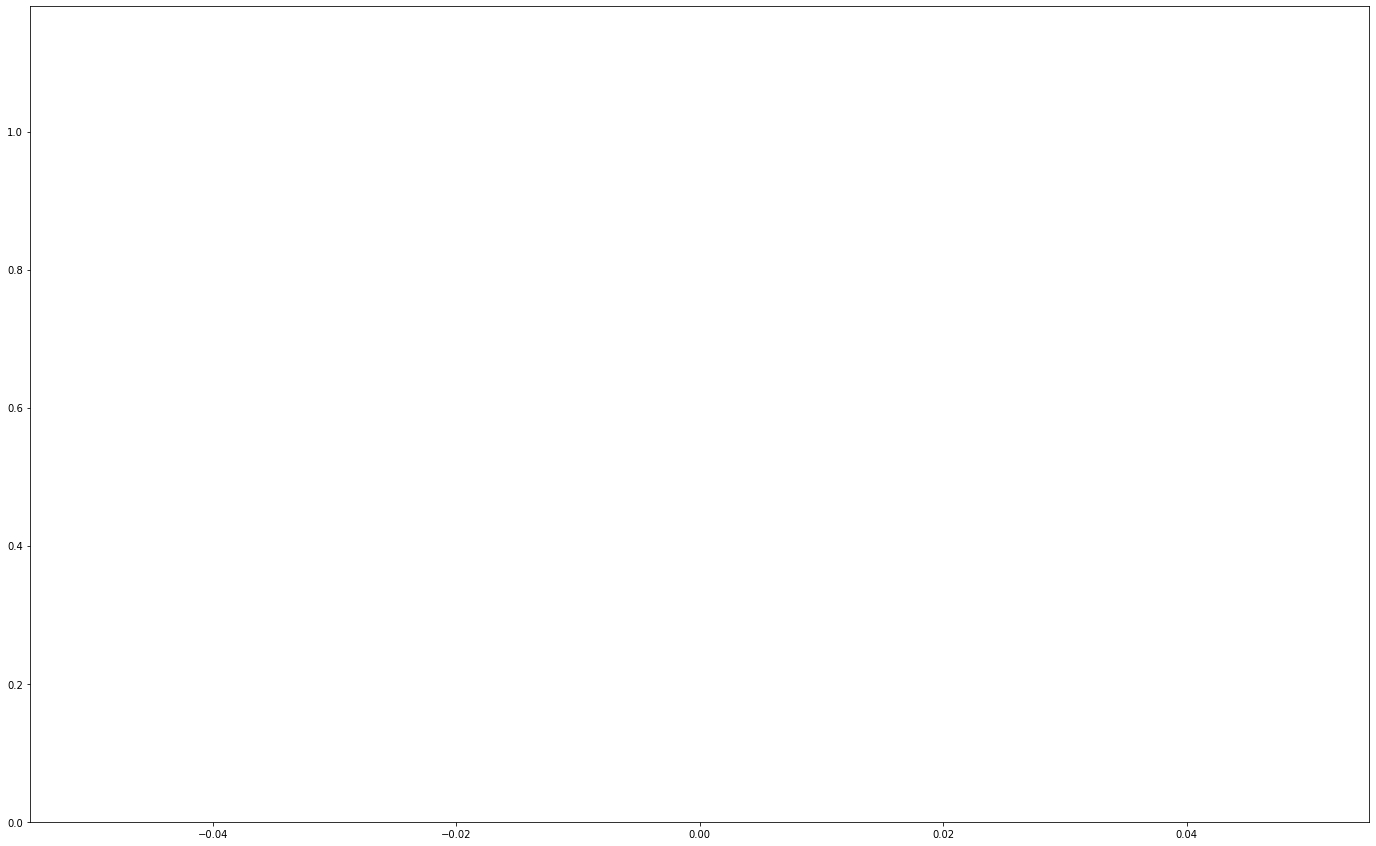

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.172544
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.124911
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.042977
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.061763
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.173300
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0.069763
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.134143
Train Epoch: 2 [35000/60000 (58%)]	Loss: 0.099411
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.161739
Train Epoch: 2 [45000/60000 (75%)]	Loss: 0.050992
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.120163
Train Epoch: 2 [55000/60000 (92%)]	Loss: 0.199892

Test set: Average loss: 0.9400, Accuracy: 37/50 (74%)



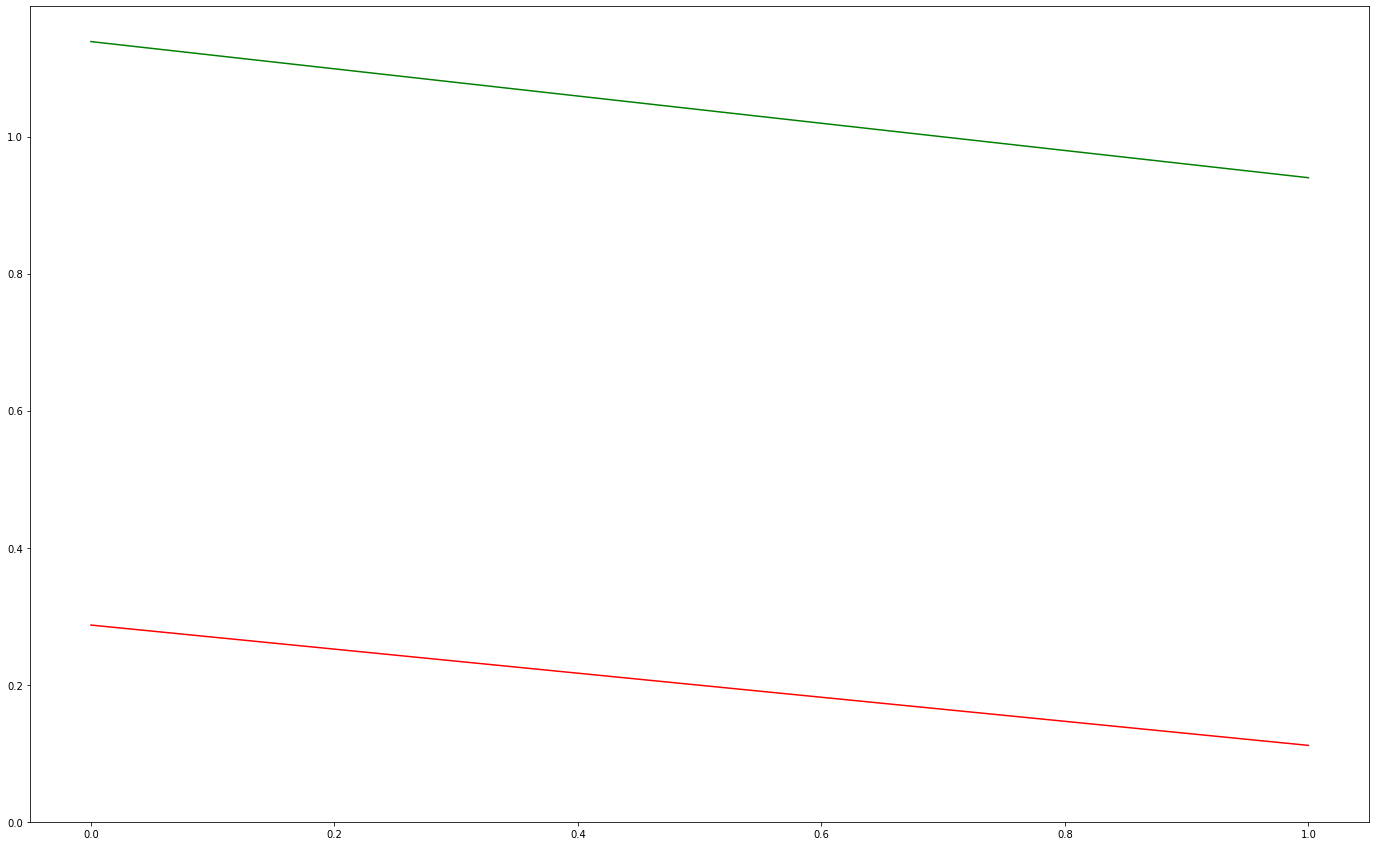

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.286237
Train Epoch: 3 [5000/60000 (8%)]	Loss: 0.004459
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.225474
Train Epoch: 3 [15000/60000 (25%)]	Loss: 0.053442
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.064061
Train Epoch: 3 [25000/60000 (42%)]	Loss: 0.082503
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.061040
Train Epoch: 3 [35000/60000 (58%)]	Loss: 0.069037
Train Epoch: 3 [40000/60000 (67%)]	Loss: 0.031652
Train Epoch: 3 [45000/60000 (75%)]	Loss: 0.219698
Train Epoch: 3 [50000/60000 (83%)]	Loss: 0.045436
Train Epoch: 3 [55000/60000 (92%)]	Loss: 0.153565

Test set: Average loss: 0.9353, Accuracy: 39/50 (78%)



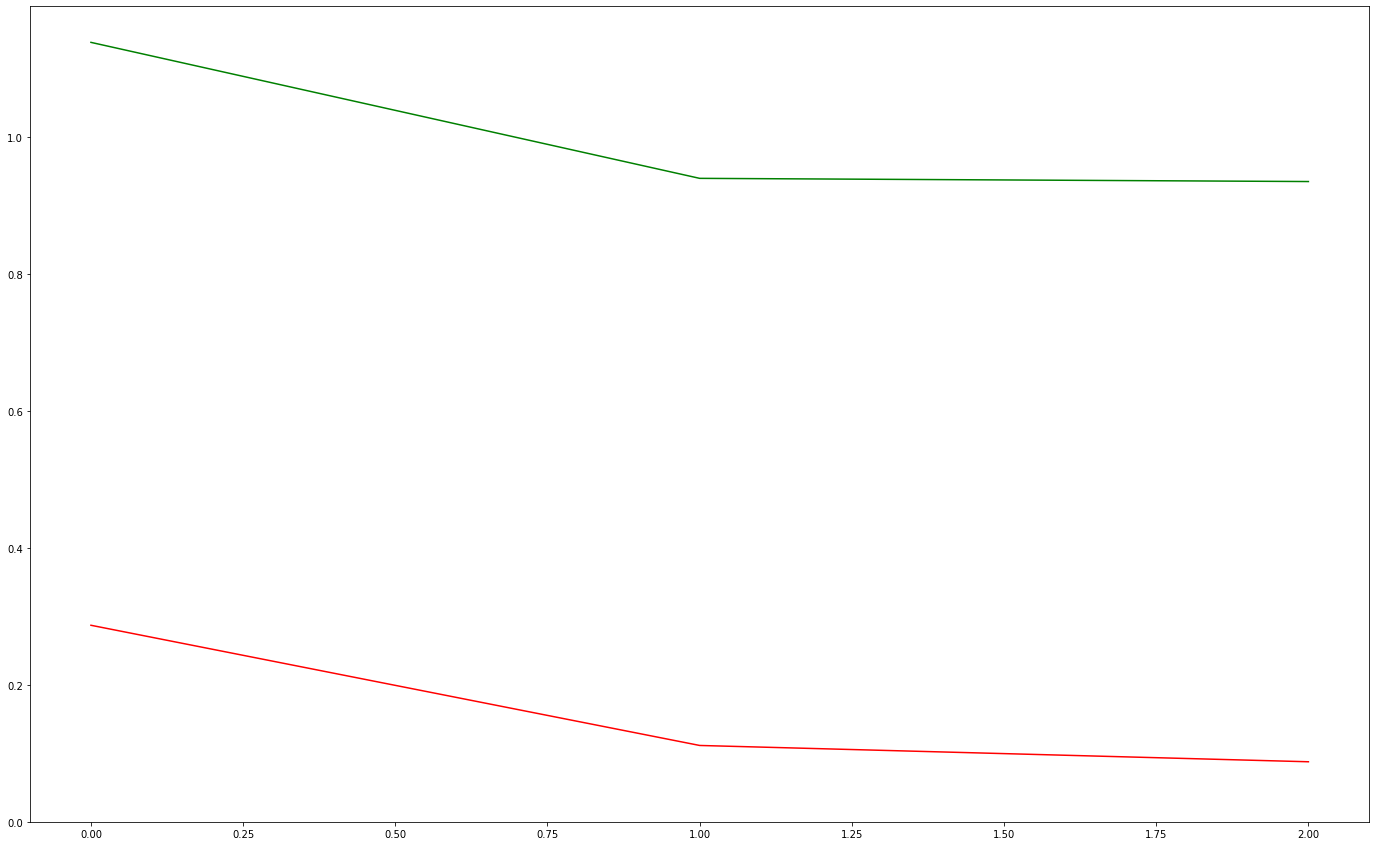

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.055861
Train Epoch: 4 [5000/60000 (8%)]	Loss: 0.135694
Train Epoch: 4 [10000/60000 (17%)]	Loss: 0.019574
Train Epoch: 4 [15000/60000 (25%)]	Loss: 0.012395
Train Epoch: 4 [20000/60000 (33%)]	Loss: 0.024685
Train Epoch: 4 [25000/60000 (42%)]	Loss: 0.022976
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.152245
Train Epoch: 4 [35000/60000 (58%)]	Loss: 0.036541
Train Epoch: 4 [40000/60000 (67%)]	Loss: 0.015550
Train Epoch: 4 [45000/60000 (75%)]	Loss: 0.048944
Train Epoch: 4 [50000/60000 (83%)]	Loss: 0.061051
Train Epoch: 4 [55000/60000 (92%)]	Loss: 0.041497

Test set: Average loss: 0.9324, Accuracy: 38/50 (76%)



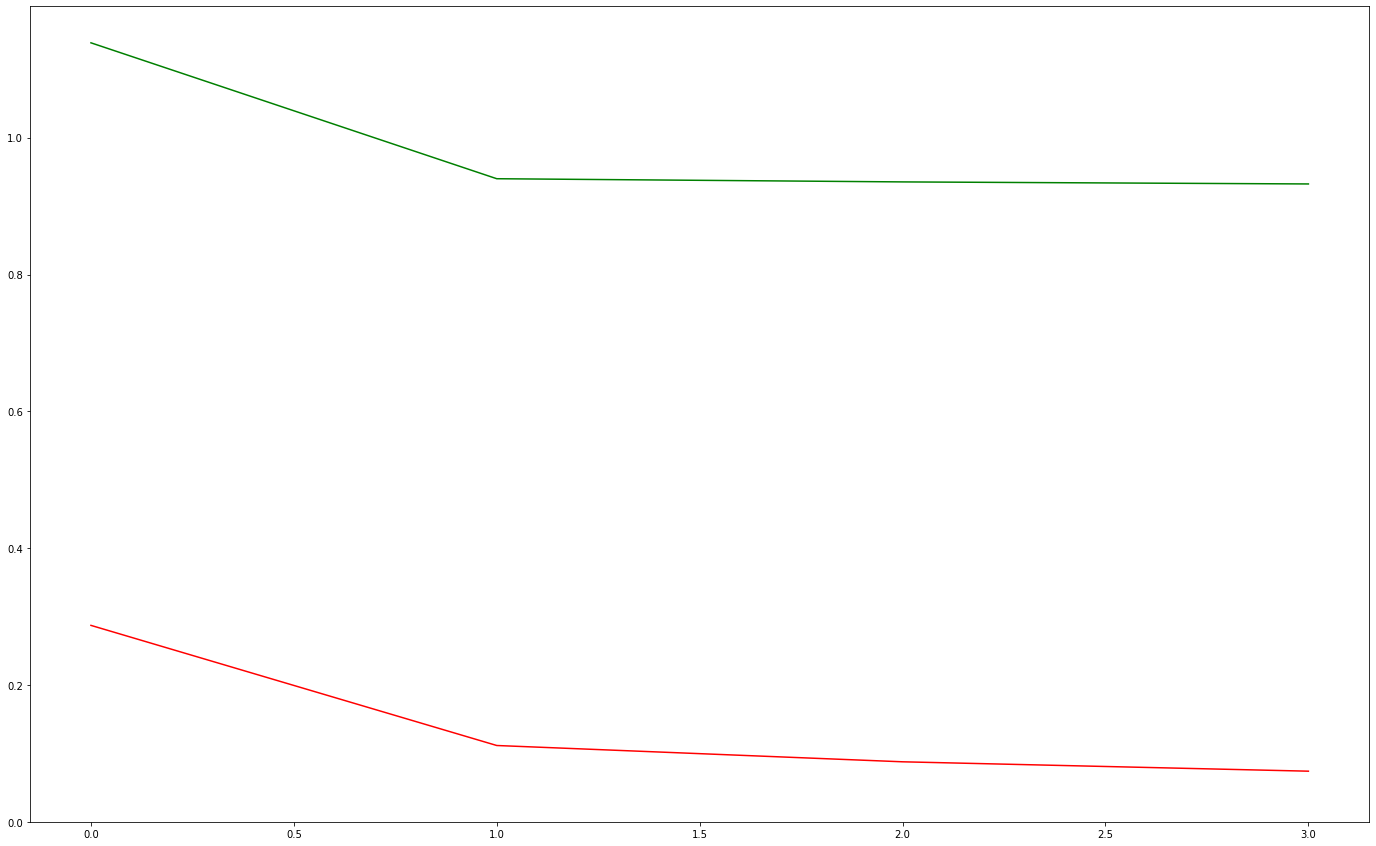

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.097353
Train Epoch: 5 [5000/60000 (8%)]	Loss: 0.064055
Train Epoch: 5 [10000/60000 (17%)]	Loss: 0.012694
Train Epoch: 5 [15000/60000 (25%)]	Loss: 0.063364
Train Epoch: 5 [20000/60000 (33%)]	Loss: 0.063860
Train Epoch: 5 [25000/60000 (42%)]	Loss: 0.015670
Train Epoch: 5 [30000/60000 (50%)]	Loss: 0.010737
Train Epoch: 5 [35000/60000 (58%)]	Loss: 0.116118
Train Epoch: 5 [40000/60000 (67%)]	Loss: 0.036017
Train Epoch: 5 [45000/60000 (75%)]	Loss: 0.138027
Train Epoch: 5 [50000/60000 (83%)]	Loss: 0.009695
Train Epoch: 5 [55000/60000 (92%)]	Loss: 0.044134

Test set: Average loss: 0.8420, Accuracy: 40/50 (80%)



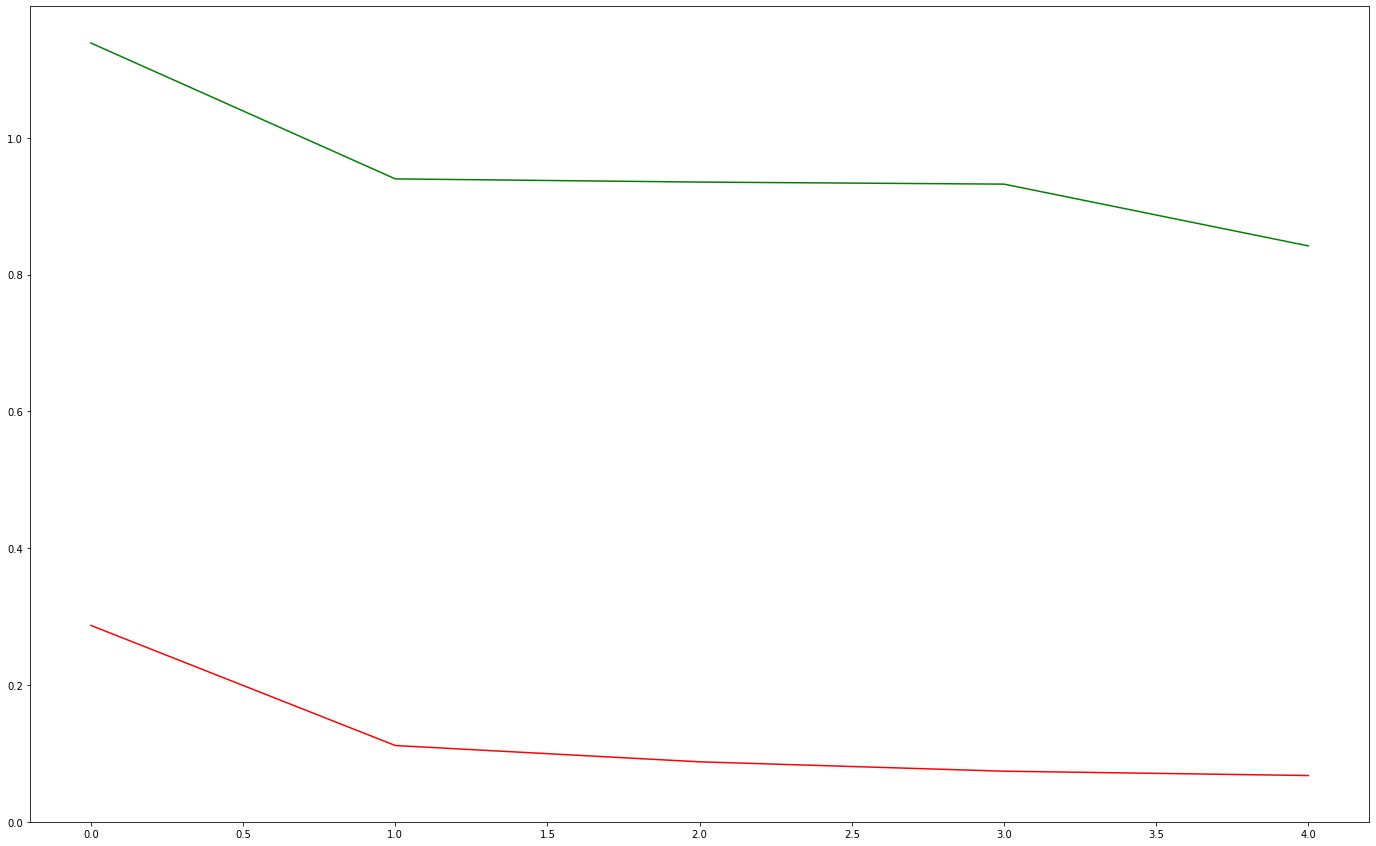

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.021045
Train Epoch: 6 [5000/60000 (8%)]	Loss: 0.004540
Train Epoch: 6 [10000/60000 (17%)]	Loss: 0.022594
Train Epoch: 6 [15000/60000 (25%)]	Loss: 0.027013
Train Epoch: 6 [20000/60000 (33%)]	Loss: 0.075554
Train Epoch: 6 [25000/60000 (42%)]	Loss: 0.072692
Train Epoch: 6 [30000/60000 (50%)]	Loss: 0.009000
Train Epoch: 6 [35000/60000 (58%)]	Loss: 0.024489
Train Epoch: 6 [40000/60000 (67%)]	Loss: 0.021497
Train Epoch: 6 [45000/60000 (75%)]	Loss: 0.139220
Train Epoch: 6 [50000/60000 (83%)]	Loss: 0.049036
Train Epoch: 6 [55000/60000 (92%)]	Loss: 0.024591

Test set: Average loss: 0.8703, Accuracy: 40/50 (80%)



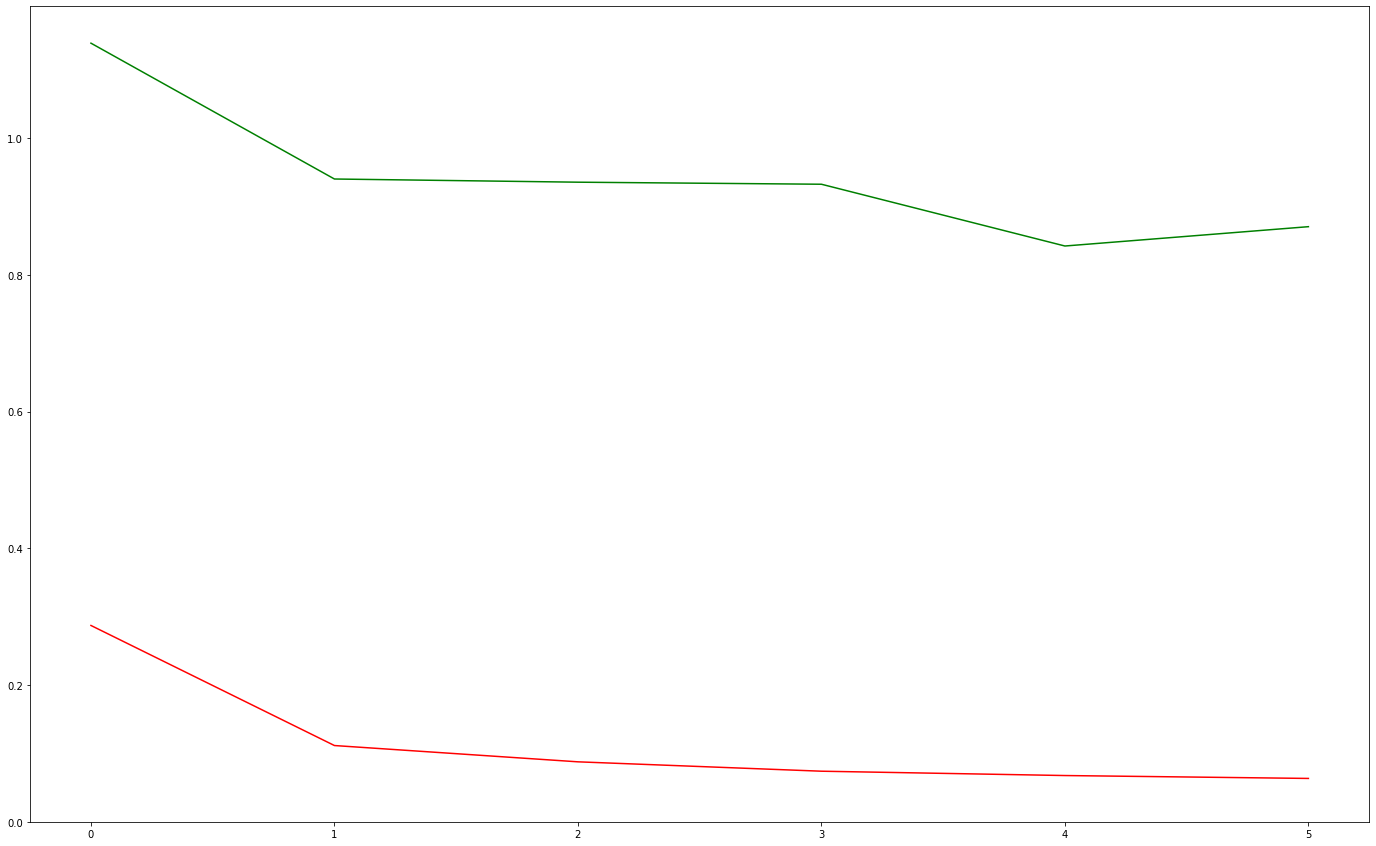

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.055248
Train Epoch: 7 [5000/60000 (8%)]	Loss: 0.109049
Train Epoch: 7 [10000/60000 (17%)]	Loss: 0.068261
Train Epoch: 7 [15000/60000 (25%)]	Loss: 0.158999
Train Epoch: 7 [20000/60000 (33%)]	Loss: 0.078146
Train Epoch: 7 [25000/60000 (42%)]	Loss: 0.072781
Train Epoch: 7 [30000/60000 (50%)]	Loss: 0.102892
Train Epoch: 7 [35000/60000 (58%)]	Loss: 0.024211
Train Epoch: 7 [40000/60000 (67%)]	Loss: 0.008694
Train Epoch: 7 [45000/60000 (75%)]	Loss: 0.007163
Train Epoch: 7 [50000/60000 (83%)]	Loss: 0.072430
Train Epoch: 7 [55000/60000 (92%)]	Loss: 0.092500

Test set: Average loss: 0.8803, Accuracy: 40/50 (80%)



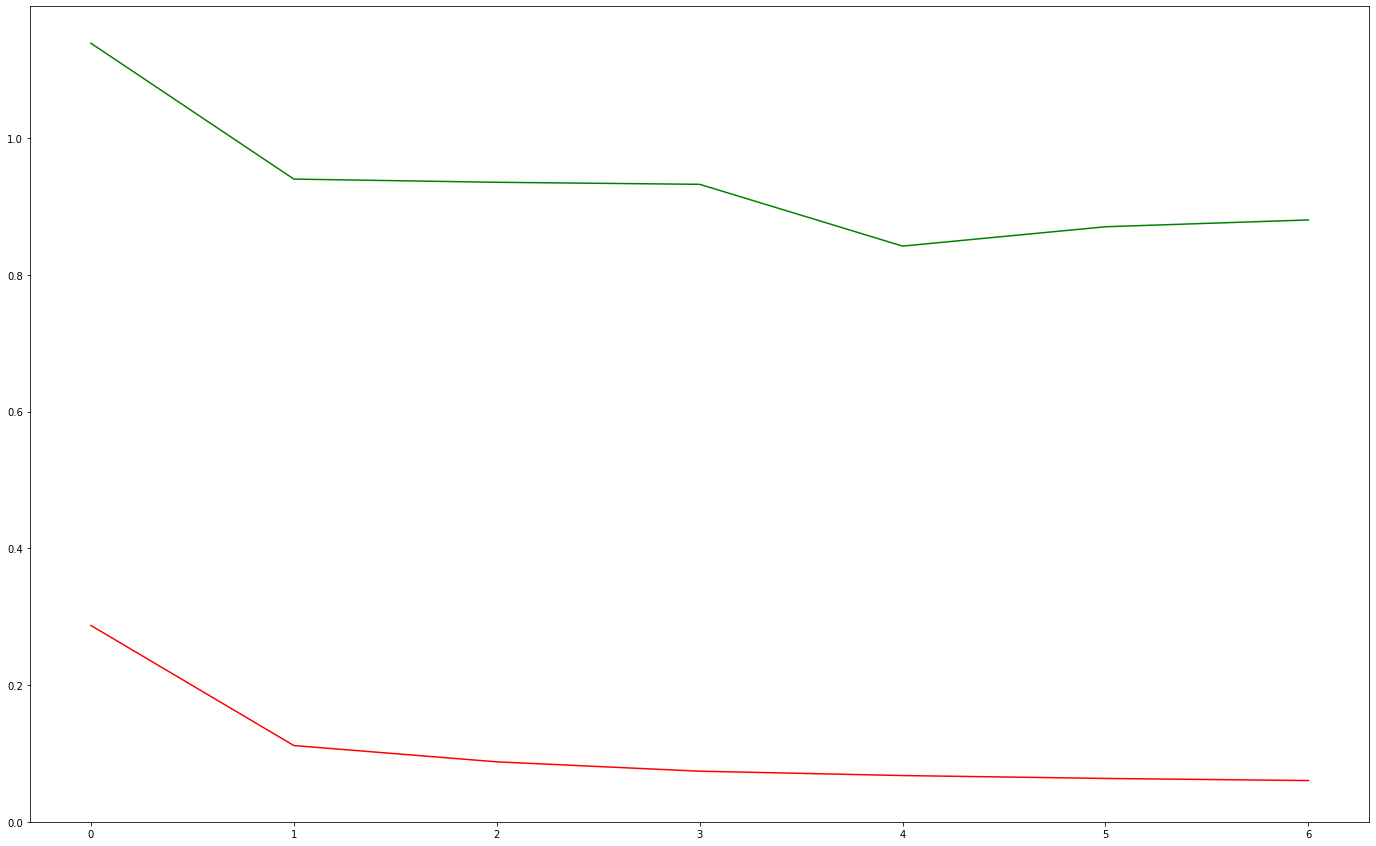

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.028690
Train Epoch: 8 [5000/60000 (8%)]	Loss: 0.047367
Train Epoch: 8 [10000/60000 (17%)]	Loss: 0.018003
Train Epoch: 8 [15000/60000 (25%)]	Loss: 0.029079
Train Epoch: 8 [20000/60000 (33%)]	Loss: 0.025818
Train Epoch: 8 [25000/60000 (42%)]	Loss: 0.026932
Train Epoch: 8 [30000/60000 (50%)]	Loss: 0.036932
Train Epoch: 8 [35000/60000 (58%)]	Loss: 0.009029
Train Epoch: 8 [40000/60000 (67%)]	Loss: 0.024677
Train Epoch: 8 [45000/60000 (75%)]	Loss: 0.056646
Train Epoch: 8 [50000/60000 (83%)]	Loss: 0.015200
Train Epoch: 8 [55000/60000 (92%)]	Loss: 0.021230

Test set: Average loss: 0.8747, Accuracy: 40/50 (80%)



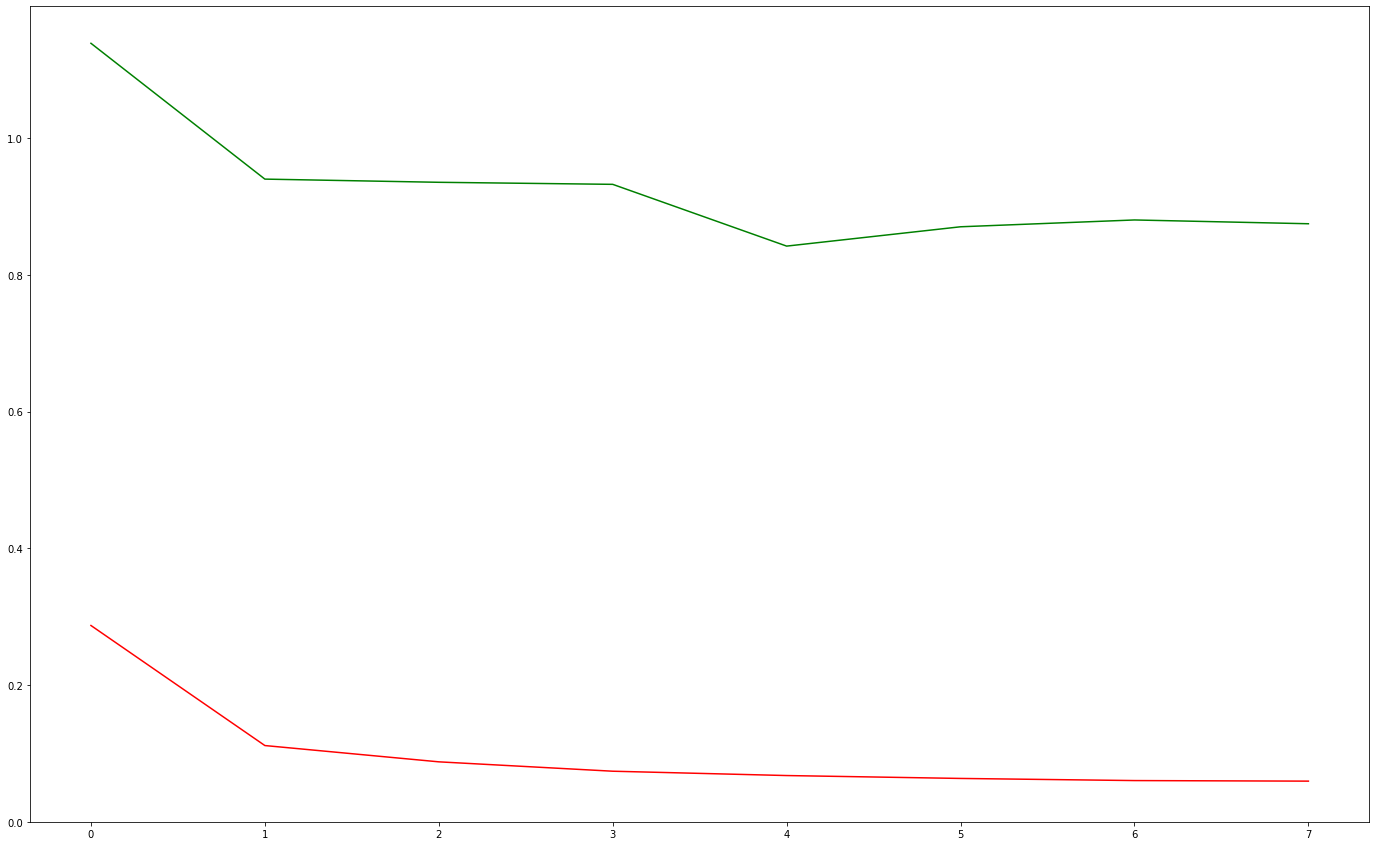

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.046821
Train Epoch: 9 [5000/60000 (8%)]	Loss: 0.102169
Train Epoch: 9 [10000/60000 (17%)]	Loss: 0.013813
Train Epoch: 9 [15000/60000 (25%)]	Loss: 0.009840
Train Epoch: 9 [20000/60000 (33%)]	Loss: 0.050189
Train Epoch: 9 [25000/60000 (42%)]	Loss: 0.090514
Train Epoch: 9 [30000/60000 (50%)]	Loss: 0.302250
Train Epoch: 9 [35000/60000 (58%)]	Loss: 0.030945
Train Epoch: 9 [40000/60000 (67%)]	Loss: 0.030810
Train Epoch: 9 [45000/60000 (75%)]	Loss: 0.025048
Train Epoch: 9 [50000/60000 (83%)]	Loss: 0.068500
Train Epoch: 9 [55000/60000 (92%)]	Loss: 0.054643

Test set: Average loss: 0.8629, Accuracy: 40/50 (80%)



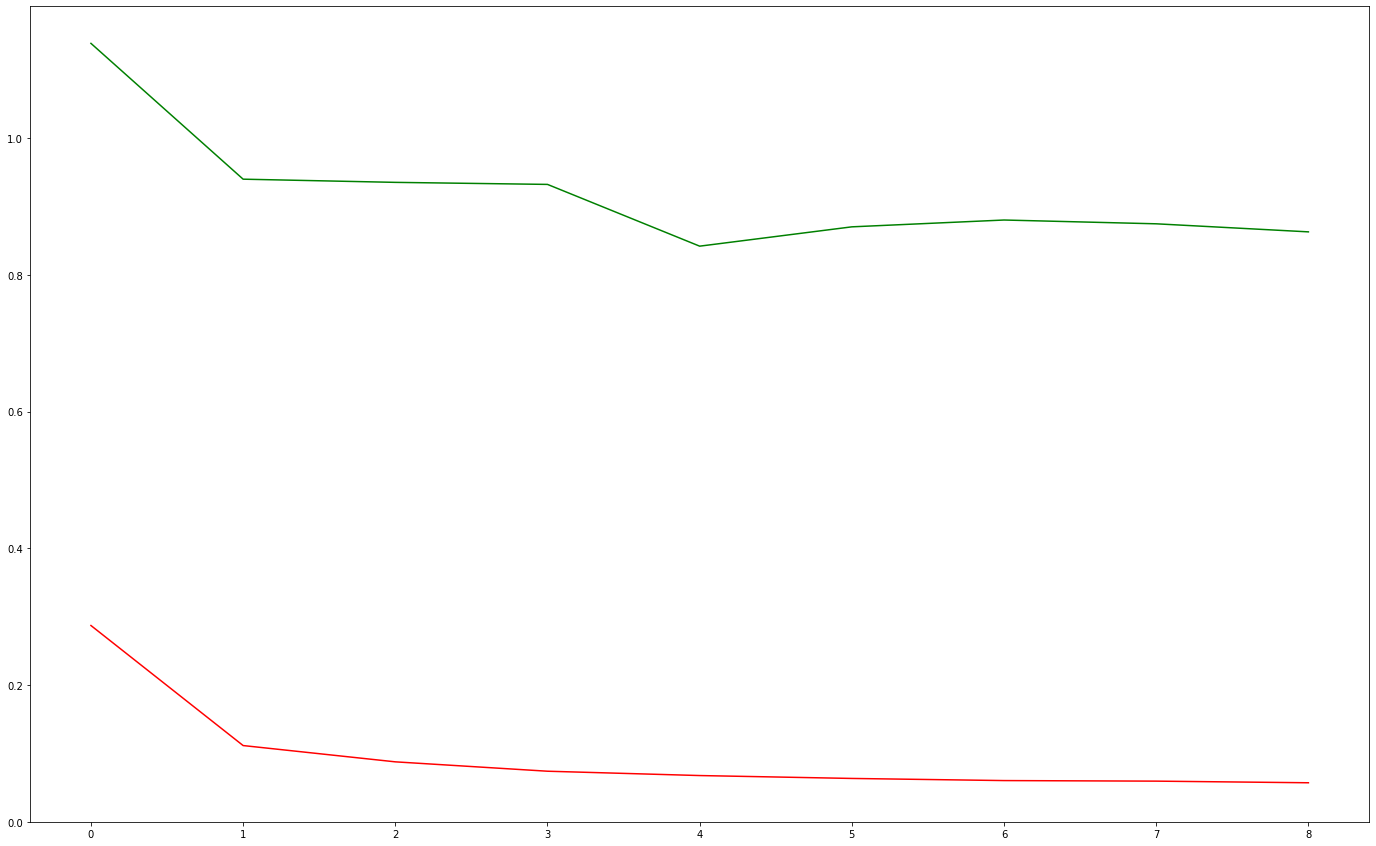

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.009838
Train Epoch: 10 [5000/60000 (8%)]	Loss: 0.008125
Train Epoch: 10 [10000/60000 (17%)]	Loss: 0.074988
Train Epoch: 10 [15000/60000 (25%)]	Loss: 0.010924
Train Epoch: 10 [20000/60000 (33%)]	Loss: 0.049520
Train Epoch: 10 [25000/60000 (42%)]	Loss: 0.007118
Train Epoch: 10 [30000/60000 (50%)]	Loss: 0.040586
Train Epoch: 10 [35000/60000 (58%)]	Loss: 0.072953
Train Epoch: 10 [40000/60000 (67%)]	Loss: 0.136141
Train Epoch: 10 [45000/60000 (75%)]	Loss: 0.282735
Train Epoch: 10 [50000/60000 (83%)]	Loss: 0.008076
Train Epoch: 10 [55000/60000 (92%)]	Loss: 0.068635

Test set: Average loss: 0.8569, Accuracy: 40/50 (80%)



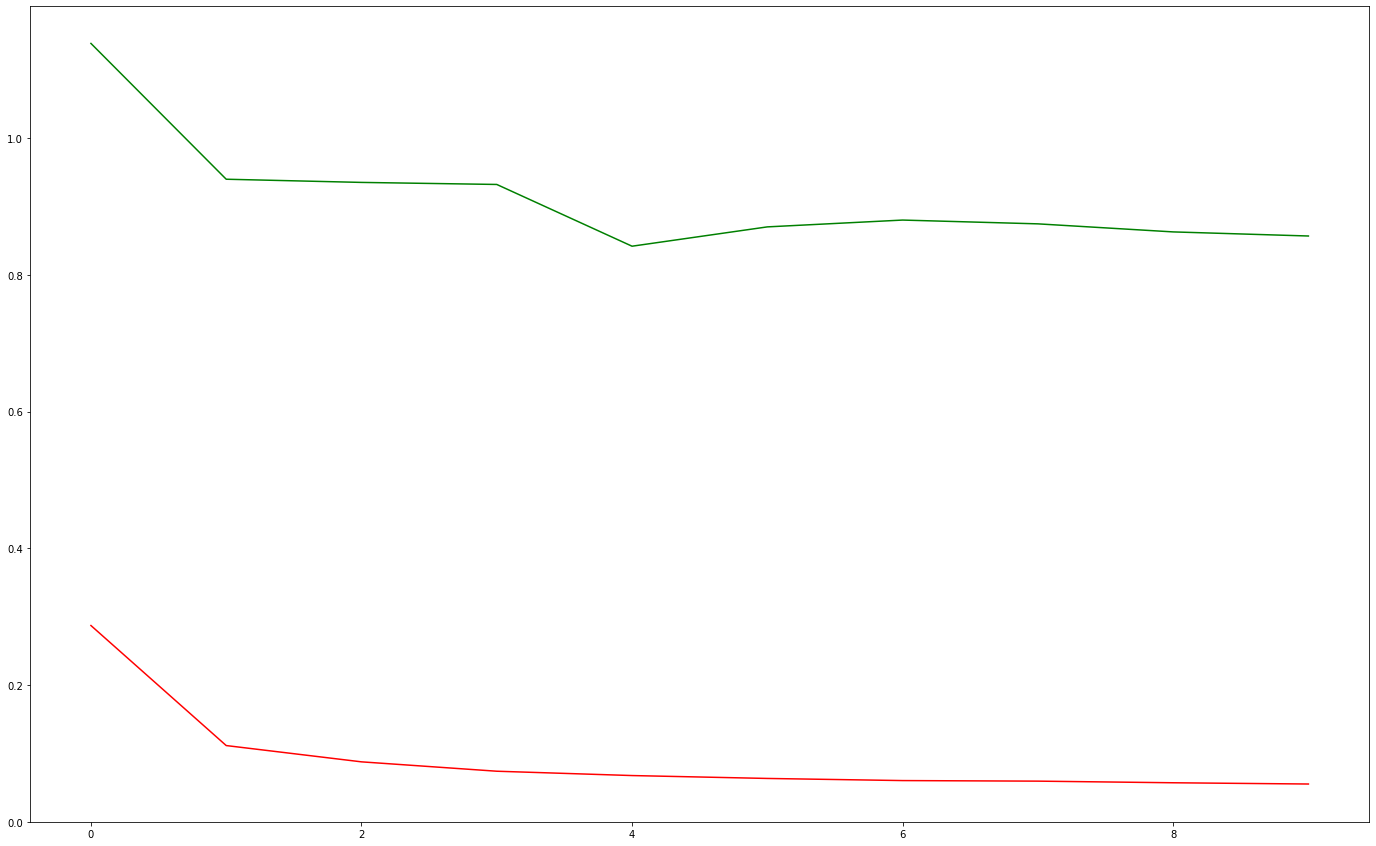

In [ ]:
epochs          = 10
lr              = 0.1
gamma           = 0.7
seed            = 1
log_interval    = 100

torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")

model = Conv_net_MNIST().to(device)

optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

train_loss = []
test_loss  = []

plt.ion()

for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch, log_interval, train_loss)
    test(model, device, test_loader, test_loss)
    scheduler.step()

    plt.figure (figsize=(24, 15))
    
    plt.plot (train_loss, 'r')
    plt.plot (test_loss, 'g')
    plt.ylim(ymin=0)

    plt.show ()

Получилось распознать 80% моих картинок
